# Match Bathymetry with Coastlines

This is a prototype for adjusting a given bathymetry dataset with a given Coastline shapefile in order to make the bathymetry values consistent.

In [1]:
#to use the full width of the browser window uncomment the code below and execute the cell
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
import sys

In [3]:
from PIL import Image

In [4]:
import pyresample

In [5]:
import matplotlib.path as mpltPath

In [6]:
from pyPoseidon.dem import *

In [7]:
from pyPoseidon.utils.fix import *

In [8]:
%matplotlib notebook

Select a Lat/Lon window and the bathymetry dataset that will be used. 

In [9]:
dic = {'minlon':-35., # lat/lon window
       'maxlon':43.,
       'minlat':24.5,
       'maxlat':76.5,
       'dpath':'/Users/brey/DATA/GEBCO_2014_2D.nc'}

In [9]:
dic = {'minlon': 0., # lat/lon window
       'maxlon' : 13.,
       'minlat' : 57.,
       'maxlat' : 66.5,
       'dpath':'/Users/brey/DATA/emodnet_bathymetry.nc'}

Create the grid with a given resolution

In [10]:
## lat,lon grid
resolution=.1
lon=np.arange(dic['minlon'],dic['maxlon'],resolution)
lat=np.arange(dic['minlat'],dic['maxlat'],resolution)
xp, yp = np.meshgrid(lon,lat)

In [11]:
dic.update({'grid_x':xp, 'grid_y':yp}) #for using pyPoseidon

In [12]:
points=zip(xp.flatten(),yp.flatten()) # create a pool of data points from the grid 

In [13]:
#help function
def get_key(item):
    return item[1]

In [14]:
#help function
class Basemap(Basemap):
    """ Modify Basemap to use Natural Earth data instead of GSHHG data """
    def drawcoastlines(self):
        shapefile = '/Users/brey/DATA/COASTLINES/naturalearth/coastline/ne_%sm_coastline' % \
                    {'l':110, 'i':50, 'h':10}[self.resolution]
        self.readshapefile(shapefile, 'coastline', linewidth=1.)
#    def drawcountries(self):
#        shapefile = '/Users/brey/Downloads/data/naturalearth/countries/ne_%sm_admin_0_countries' % \
#                    {'l':110, 'm':50, 'h':10}[self.resolution]
#        self.readshapefile(shapefile, 'countries', linewidth=0.5)



## Give the Coastline shapefile

The shapefile file is used as input

In [15]:
shapefile = '/Users/brey/DATA/COASTLINES/naturalearth/coastline/ne_%sm_coastline.shp' % \
                    {'l':110, 'i':50, 'h':10}['i']

## Read bathymetry from the dataset defined above

In [16]:
b = emodnet(**dic) #using pyPoseidon
#b = gebco(**dic)


extracting dem from /Users/brey/DATA/emodnet_bathymetry.nc

dem done


In [17]:
b.Dataset #show

<xarray.Dataset>
Dimensions:  (dlat: 4562, dlon: 6242, i: 4562, ilat: 95, ilon: 130, j: 6242, k: 95, l: 130)
Coordinates:
  * dlat     (dlat) float64 57.0 57.0 57.0 57.0 57.01 57.01 57.01 57.01 ...
  * dlon     (dlon) float64 -0.001099 0.0009841 0.003067 0.005151 0.007234 ...
  * ilat     (ilat) float64 57.0 57.1 57.2 57.3 57.4 57.5 57.6 57.7 57.8 ...
  * ilon     (ilon) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 ...
Dimensions without coordinates: i, j, k, l
Data variables:
    dlats    (i, j) float64 57.0 57.0 57.0 57.0 57.0 57.0 57.0 57.0 57.0 ...
    val      (dlat, dlon) float64 -79.11 -80.6 -81.2 -81.9 -82.6 -83.1 -83.5 ...
    dlons    (i, j) float64 -0.001099 0.0009841 0.003067 0.005151 0.007234 ...
    ival     (ilat, ilon) float64 -80.9 -89.8 -83.3 -79.3 -80.7 -87.9 -86.8 ...
    ilats    (k, l) float64 57.0 57.0 57.0 57.0 57.0 57.0 57.0 57.0 57.0 ...
    ilons    (k, l) float64 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.1 ...

Now we apply the fix function that will adjust the grid according to the coastline shapefile by masking all the land points out. It returns the mask of the grid xp,yp that corresponds to the wet area of the grid. It also returns the part of the global shapefile given above that is relevant for our lat/lon window. 

In [18]:
wet,cg = fix(b,shapefile) # see Prototype for grid fix Notebook


optimize grid

eliminate isolated wet regions
1
2

done 


In [19]:
wet # the wet mask

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

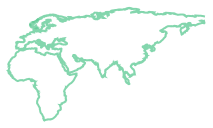

In [20]:
cg # the considered coastline

### visualize

<IPython.core.display.Javascript object>


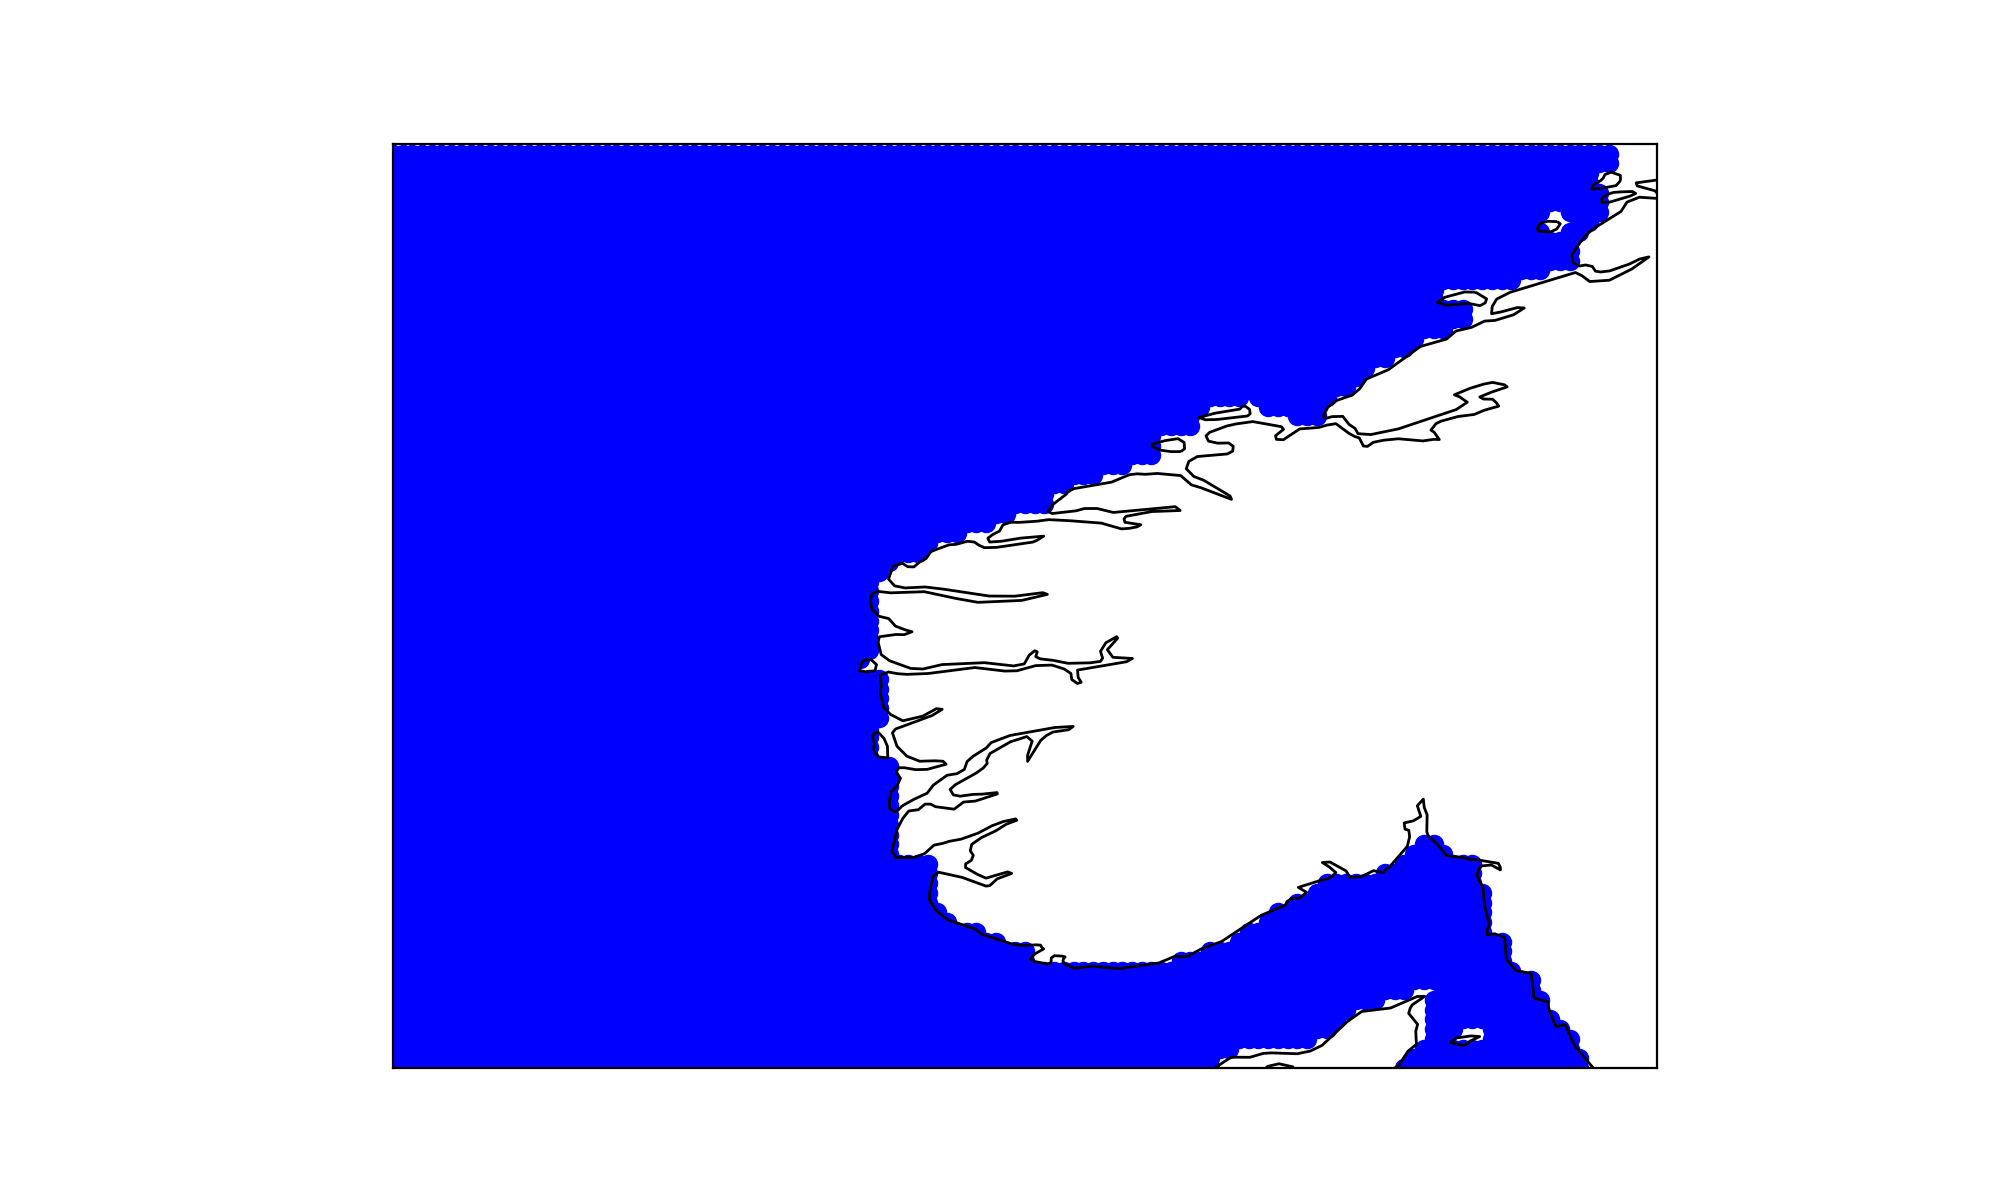

In [21]:
#Water grid area, where computation is actually performed
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()

#wet grid points
waterx=np.ma.masked_array(xp,wet)
watery=np.ma.masked_array(yp,wet)


m.scatter(waterx,watery,color='b',marker='o')

<IPython.core.display.Javascript object>


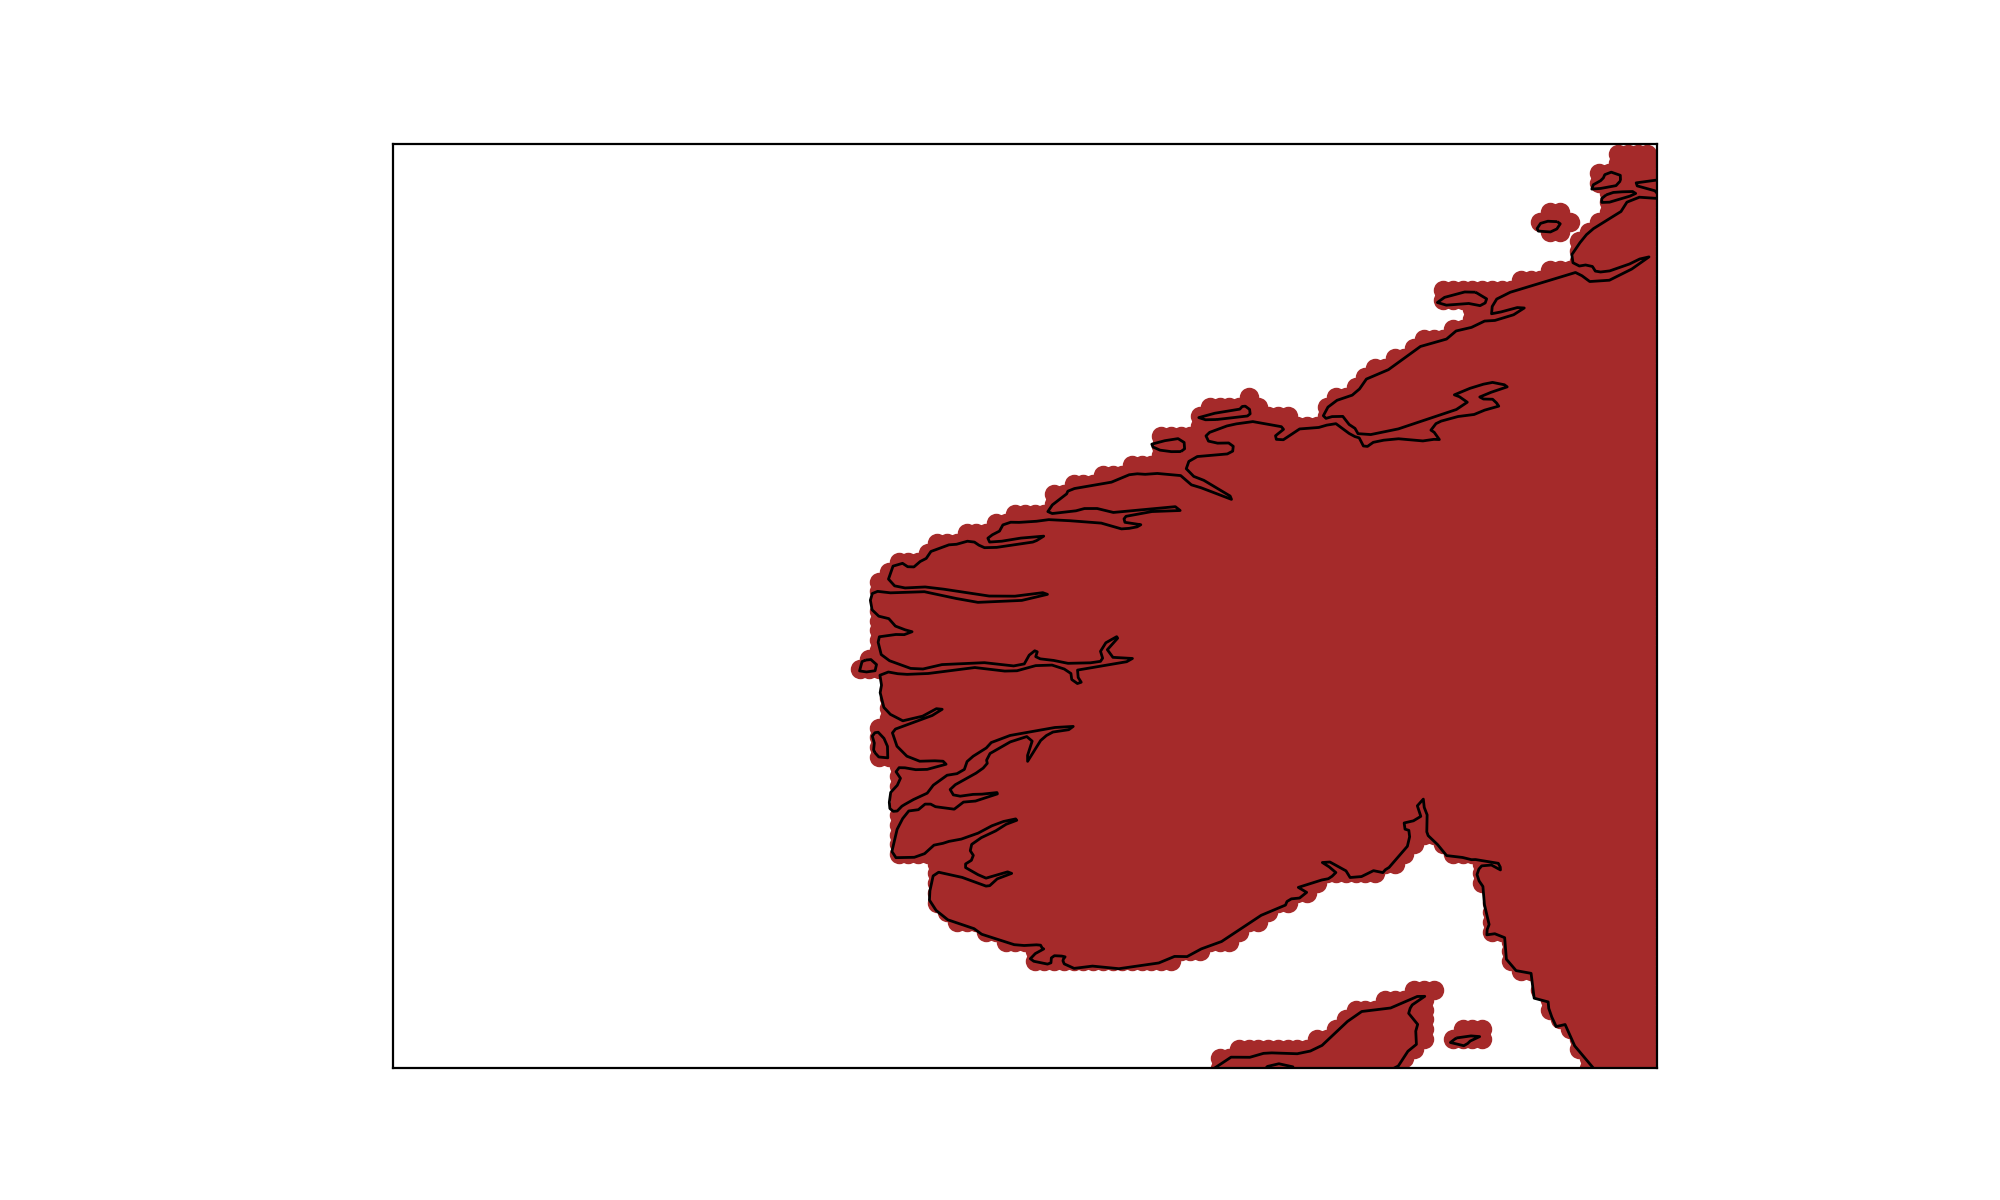

In [22]:
#Corresponding dry area. No computations
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()



#dry grid points
dryx=np.ma.masked_array(xp,np.invert(wet))
dryy=np.ma.masked_array(yp,np.invert(wet))


m.scatter(dryx,dryy,color='brown',marker='o')

### Visualize as an image

In [46]:
#im = Image.fromarray(np.flipud(wet).astype('uint8')*255)
#im.show()

In [47]:
#np.savez('/Users/brey/Downloads/water',wet)

## Mask Bathymetry data with given shorelines

From the Bathymetry dataset we get the original array

In [23]:
lons = b.Dataset.dlons.values.flatten()

In [24]:
lats = b.Dataset.dlats.values.flatten()

In [25]:
bpoints=zip(lons,lats) # arrange the points in a pool

In [26]:
len(cg) # the number of distinct coastlines in the lat/lon window 

10

In [27]:
#find which points are inside the shoreline contours that is they are on land
xb=[]
yb=[]
for i in range(len(cg)):
    z = geometry.Polygon(cg[i])
    path = mpltPath.Path(zip(z.boundary.xy[0],z.boundary.xy[1]))

    inside = path.contains_points(bpoints) #dry points

    if np.sum(inside) > 0:
        X = np.ma.masked_array(lons,mask=np.invert(inside)), #we invert to get the contrary, that is mask the wet points...
        Y = np.ma.masked_array(lats,mask=np.invert(inside))
        xb.append(X)
        yb.append(Y)

In [28]:
#merge the masks into a single one for the whole domain. Remember multiple coastlines contours....
bmask=np.ones(xb[0][0].shape, dtype=bool)
for i in range(len(xb)):
    bmask = np.logical_and(bmask,xb[i][0].mask)

/Users/brey/miniconda3/envs/dev/lib/python2.7/site-packages/pyPoseidon-0.3.0-py2.7-macosx-10.9-x86_64.egg/pyPoseidon/utils/vis.py:131: AccessorRegistrationWarning: registration of accessor <class 'pyPoseidon.utils.vis.splot'> under name 'splot' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class splot(object):


The above mask (bmask) corresponds to the points of the bathymetry dataset that are supposed to be dry based on the coastline chosen.

In [29]:
XLand = np.ma.masked_array(lons,bmask) #assumed dry points
YLand = np.ma.masked_array(lats,bmask)

<IPython.core.display.Javascript object>


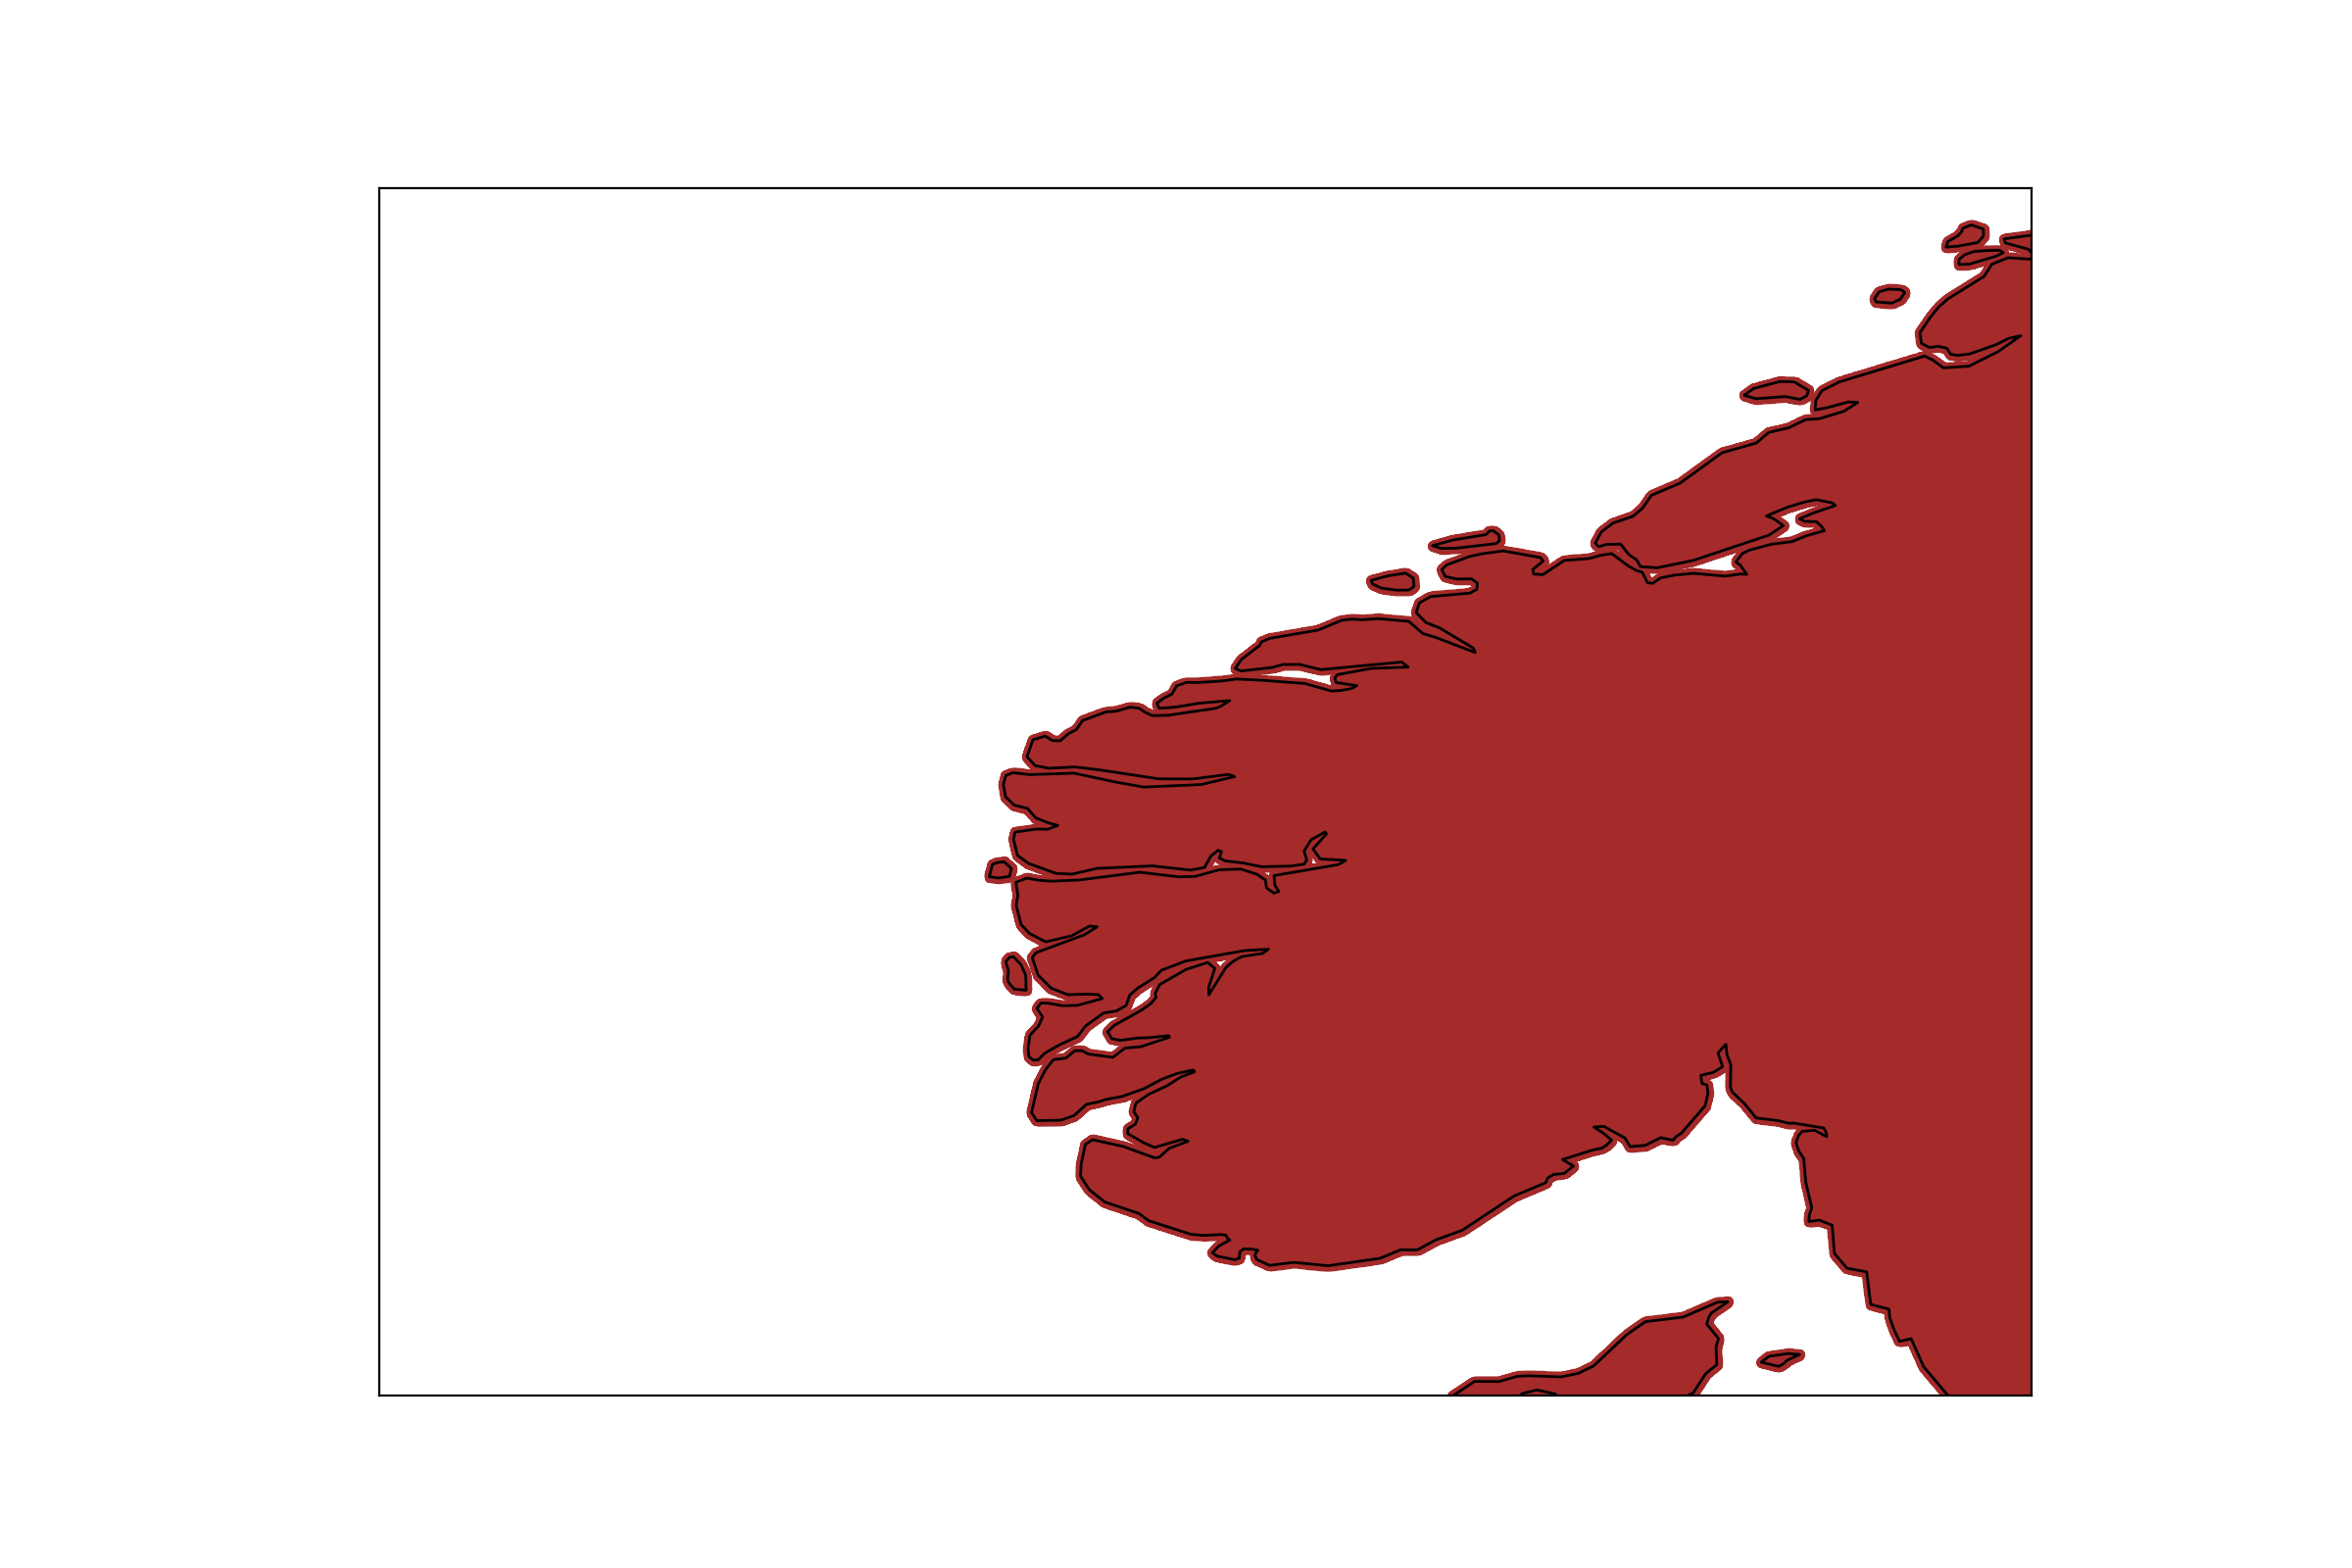

In [30]:
#Visualize
plt.figure(figsize=(12,8))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()

m.scatter(XLand,YLand,color='brown',marker='.') #plot the land bathymetry grid points

## Check Bathymetry values

Let's see if the bathymetry and the Coastlines match.

In [31]:
vals = b.Dataset.val.values.flatten() #get the (original) values for the bathymetry dataset. Flatten to make a pool of data...

In [32]:
#mask the nan, optional...
mvals = np.ma.masked_invalid(vals)

In [33]:
#since nans are not good to comparison we change to a large positive number all Nan values. This way, we can later compute values there ...
vals[np.isnan(vals)] = 99999.

In [34]:
mBL = np.ma.masked_array(mvals, mask=bmask) # the masked values of bathymetry for the assumed wet region. We use mvals to avoid the NaNs

In [35]:
mBL.min(), mBL.max() # we see that there are positive values where there shouldn't. In addition, there might be NaN values

(-1249.800048828125, 240.83999633789062)

The above mask (bmask) corresponds to the points of the bathymetry dataset that are supposed to be dry based on the coastline chosen.

to test the appearance of NaNs in the wet region...

In [36]:
BL = np.ma.masked_array(vals, mask=bmask) # the masked values of bathymetry for the assumed wet region. We use vals to include the NaNs

In [37]:
BL.min(), BL.max() # if the values differ from above there are NaN values

(-1249.800048828125, 99999.0)

### Get the wet area

In [38]:
XWater = np.ma.masked_array(lons,mask=np.invert(bmask)) #we invert bmask to get the wet area
YWater = np.ma.masked_array(lats,mask=np.invert(bmask))

BW = np.ma.masked_array(vals, mask=np.invert(bmask))

<IPython.core.display.Javascript object>


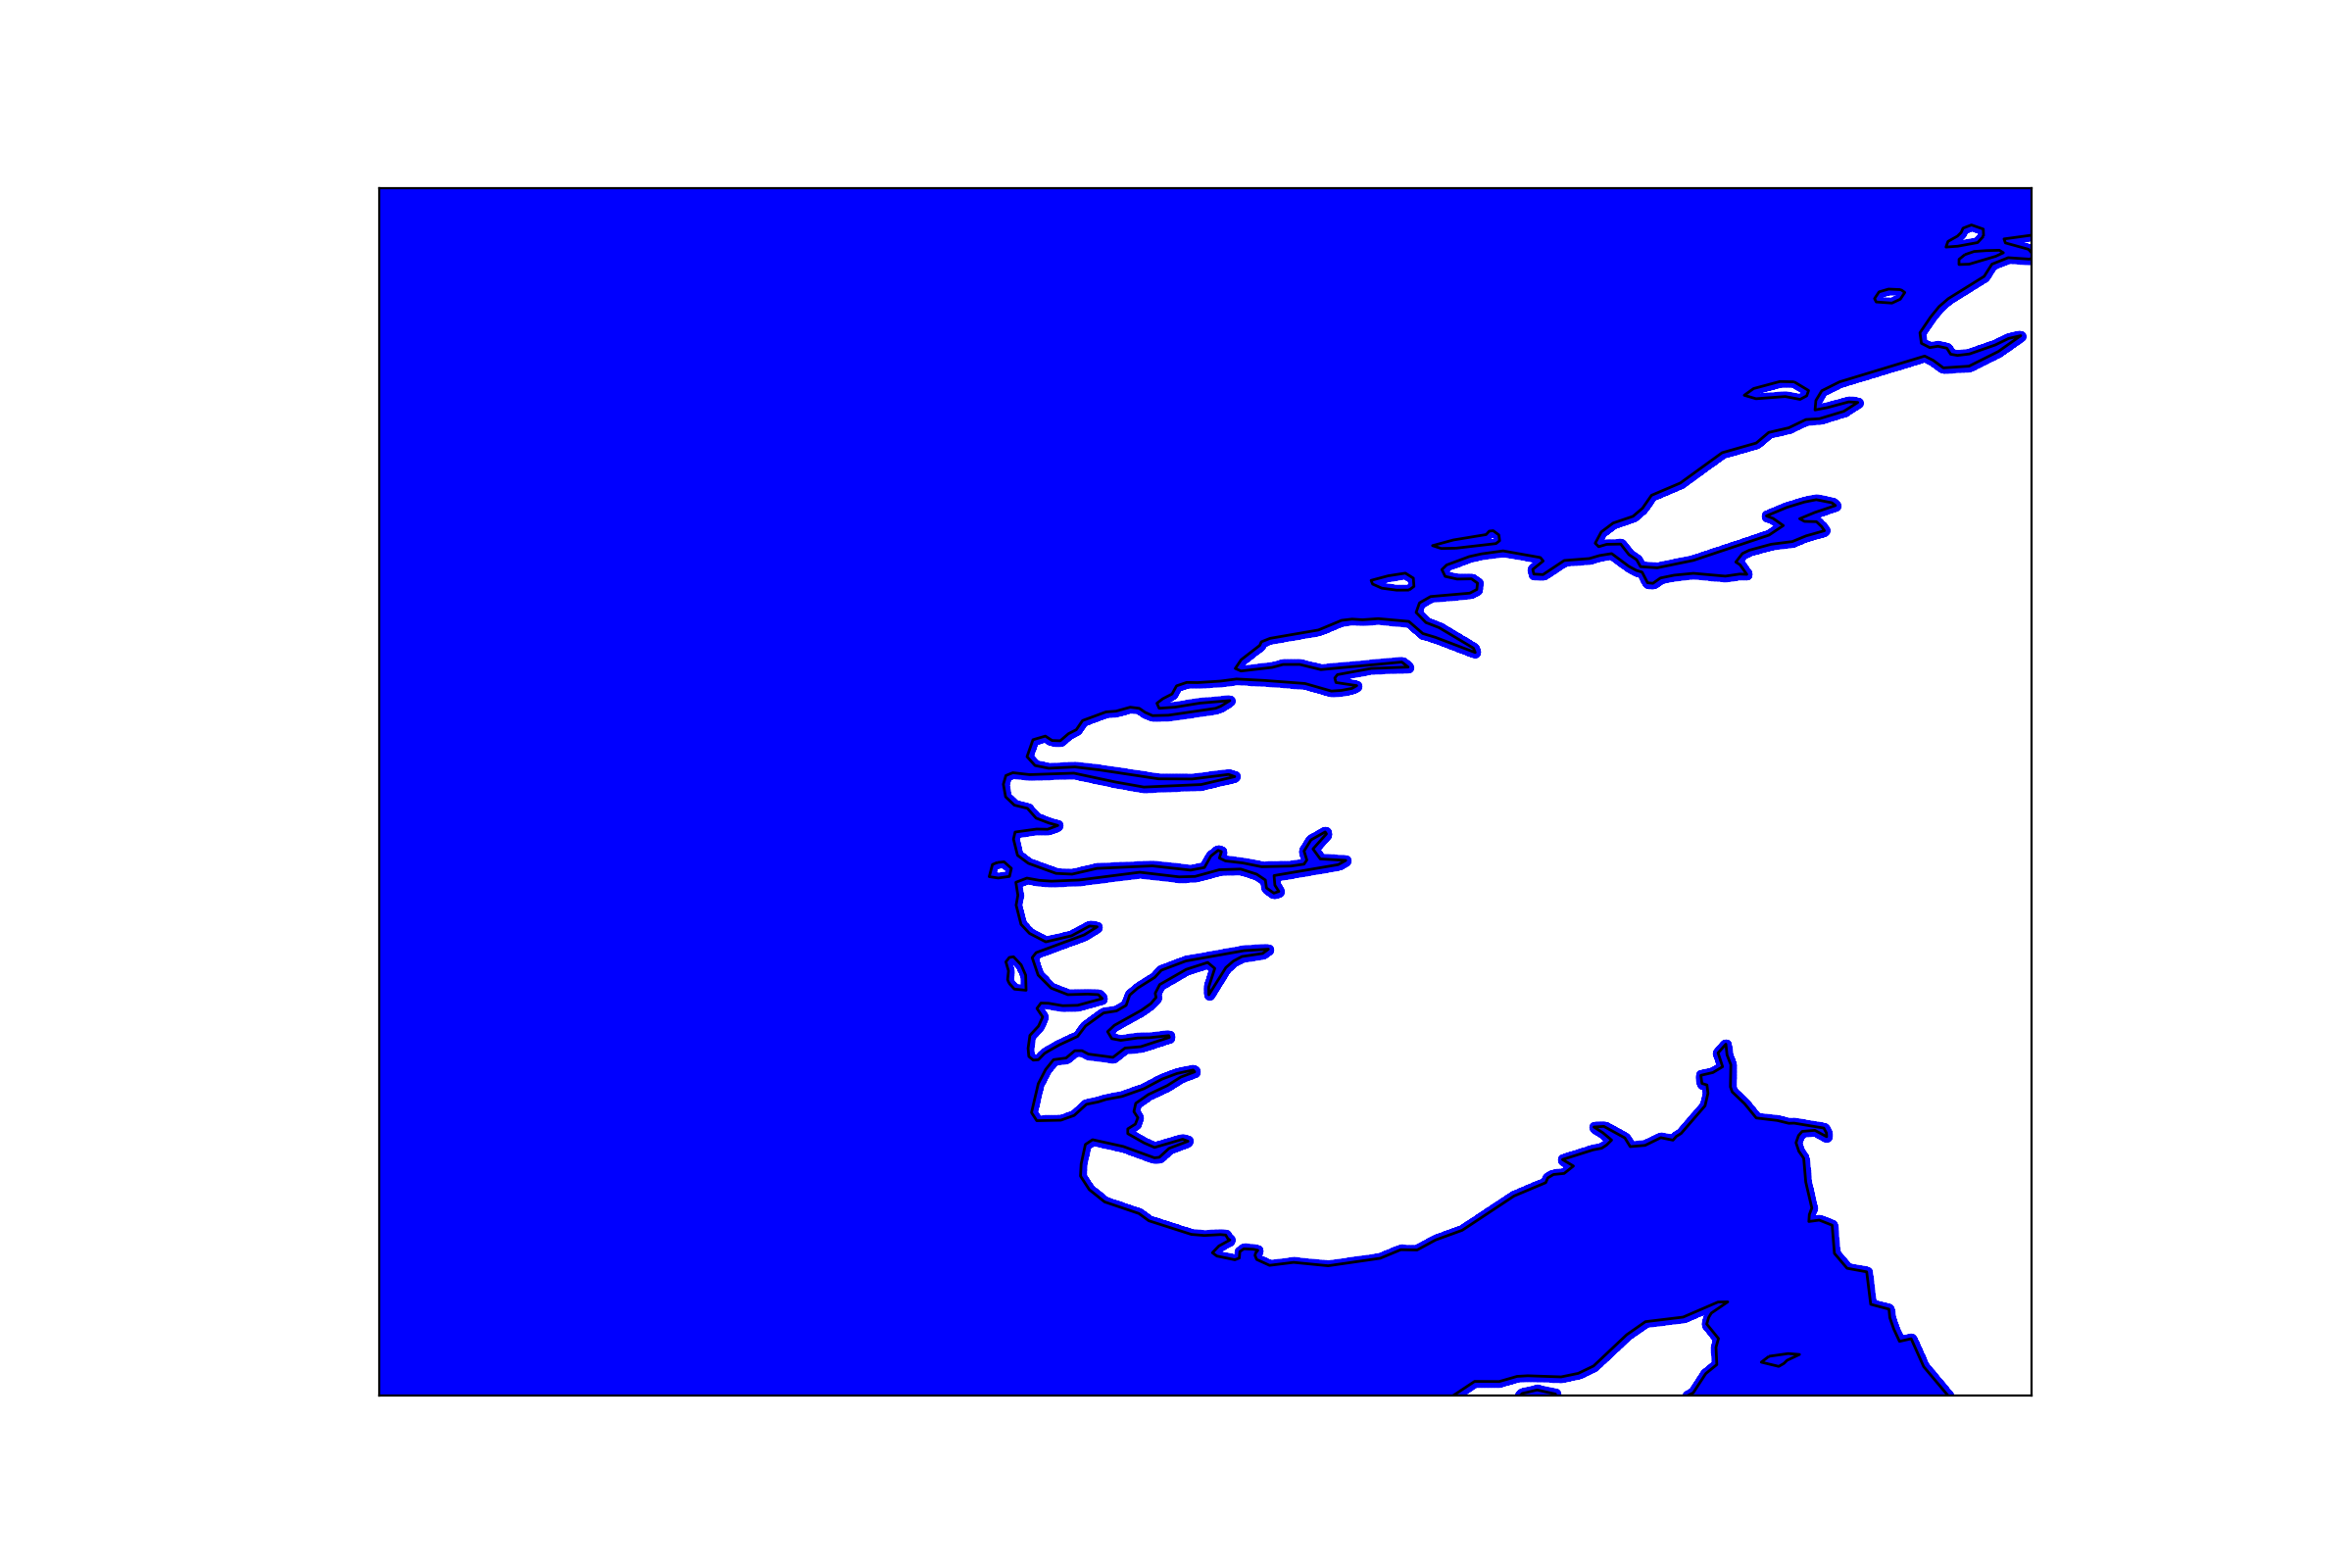

In [39]:
#Visualize
plt.figure(figsize=(12,8))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()

m.scatter(XWater,YWater,color='b',marker='.') #plot the land bathymetry grid points

## isolate discrepancies

### wet points on land

In [40]:
# We join masks for negative value points and points on water. That leaves out the wet points on land, including NaNs
wlmask = np.logical_and(vals<0,np.invert(bmask)) 

In [41]:
np.sum(wlmask)

244793

In [42]:
Xwl = np.ma.masked_array(lons,mask=np.invert(wlmask)) #only wet points on land
Ywl = np.ma.masked_array(lats,mask=np.invert(wlmask))

In [43]:
Bwl = np.ma.masked_array(vals, mask=np.invert(wlmask))

<IPython.core.display.Javascript object>


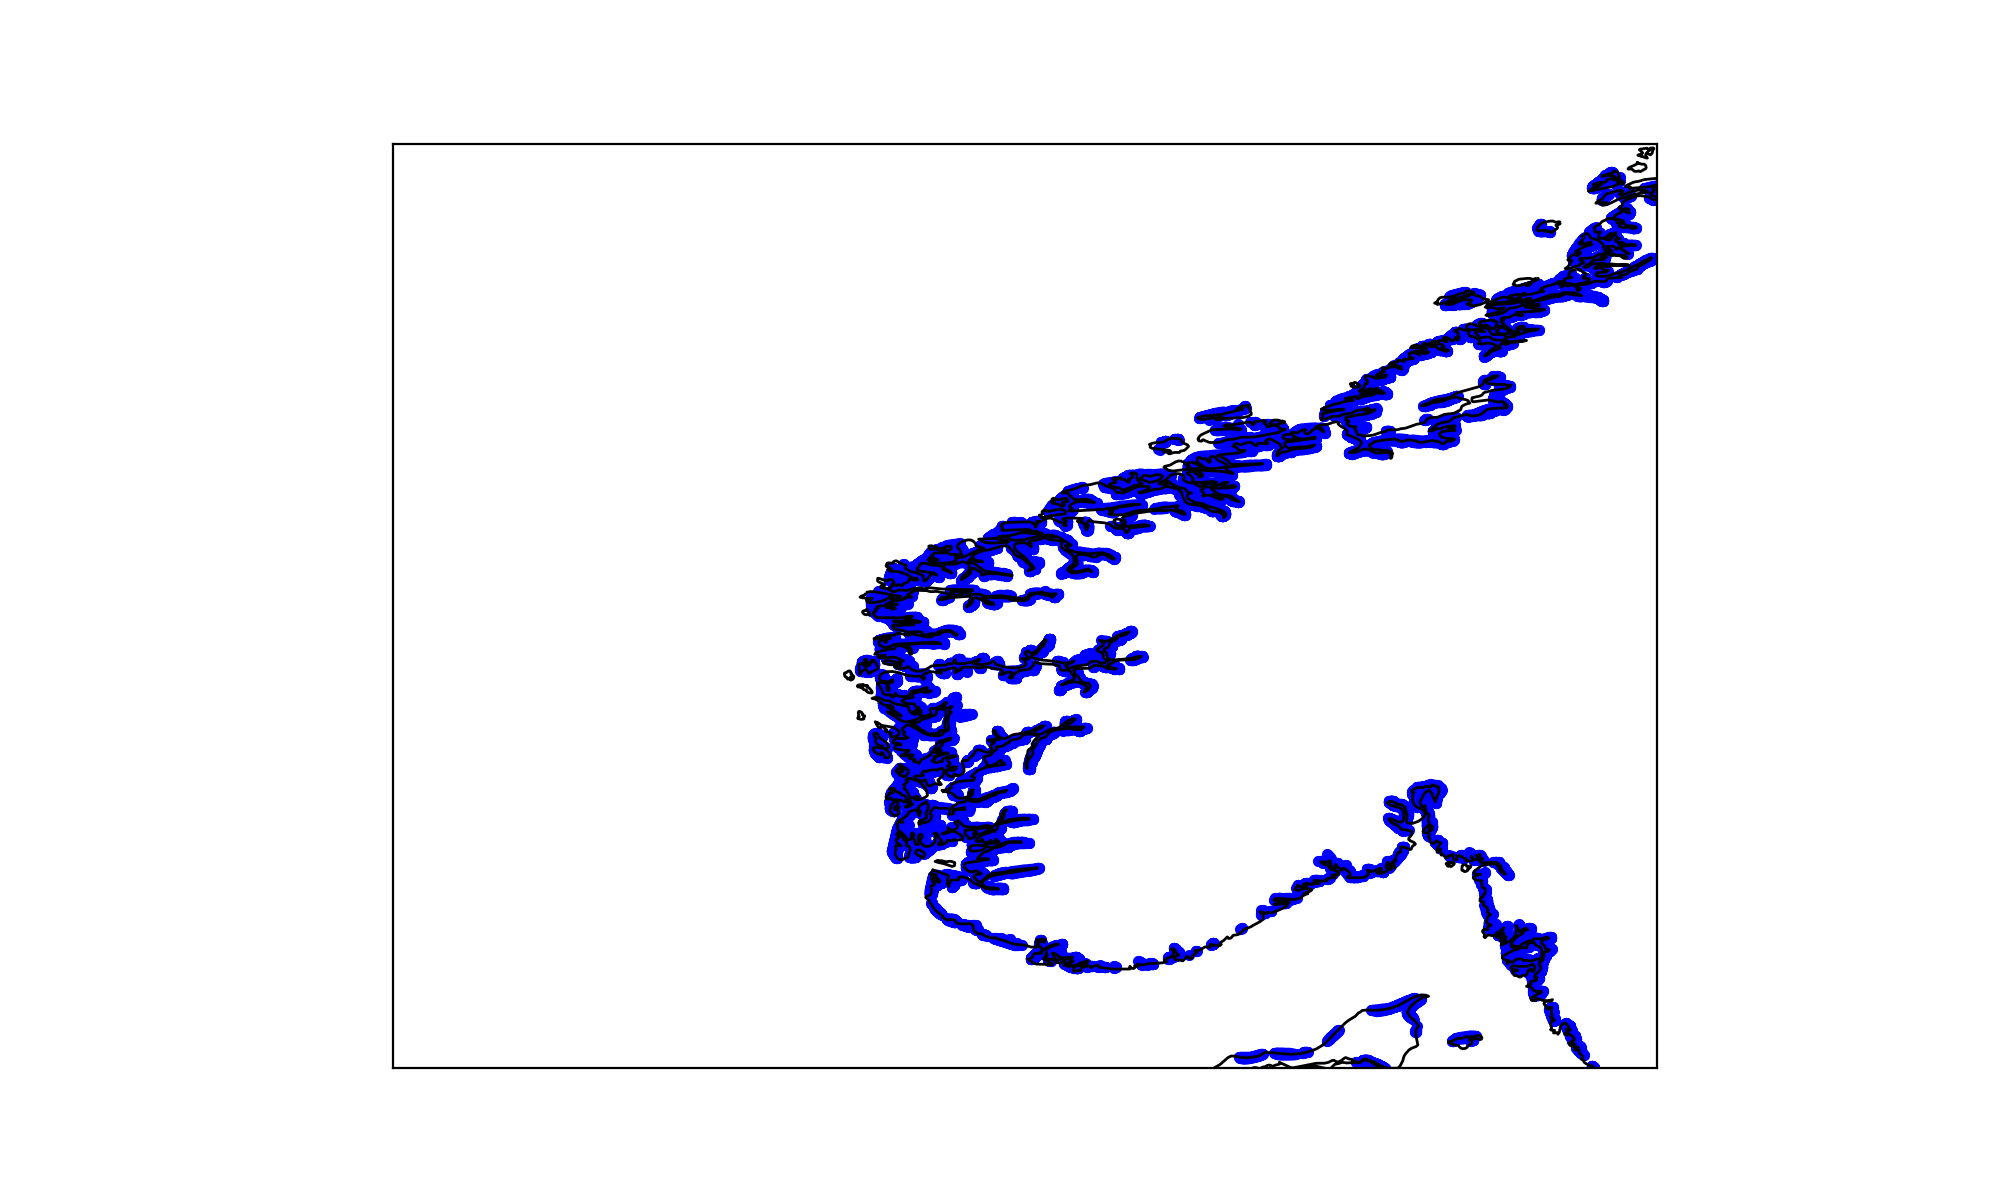

In [45]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='h')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()

m.scatter(Xwl,Ywl,color='b',marker='.') #plot

### dry point on water

In [46]:
# We join masks for positive value points and points on land. That leaves out the dry points on water. NaNs are excluded because we replaced them with 99999.
lwmask = np.logical_and(vals>0,bmask) # positive bathymetry & outside shorelines

In [47]:
np.sum(lwmask)

440549

In [48]:
Xlw = np.ma.masked_array(lons,mask=np.invert(lwmask)) #only dry points on water, Including Nans
Ylw = np.ma.masked_array(lats,mask=np.invert(lwmask))

In [49]:
Blw = np.ma.masked_array(vals, mask=np.invert(lwmask))

<IPython.core.display.Javascript object>


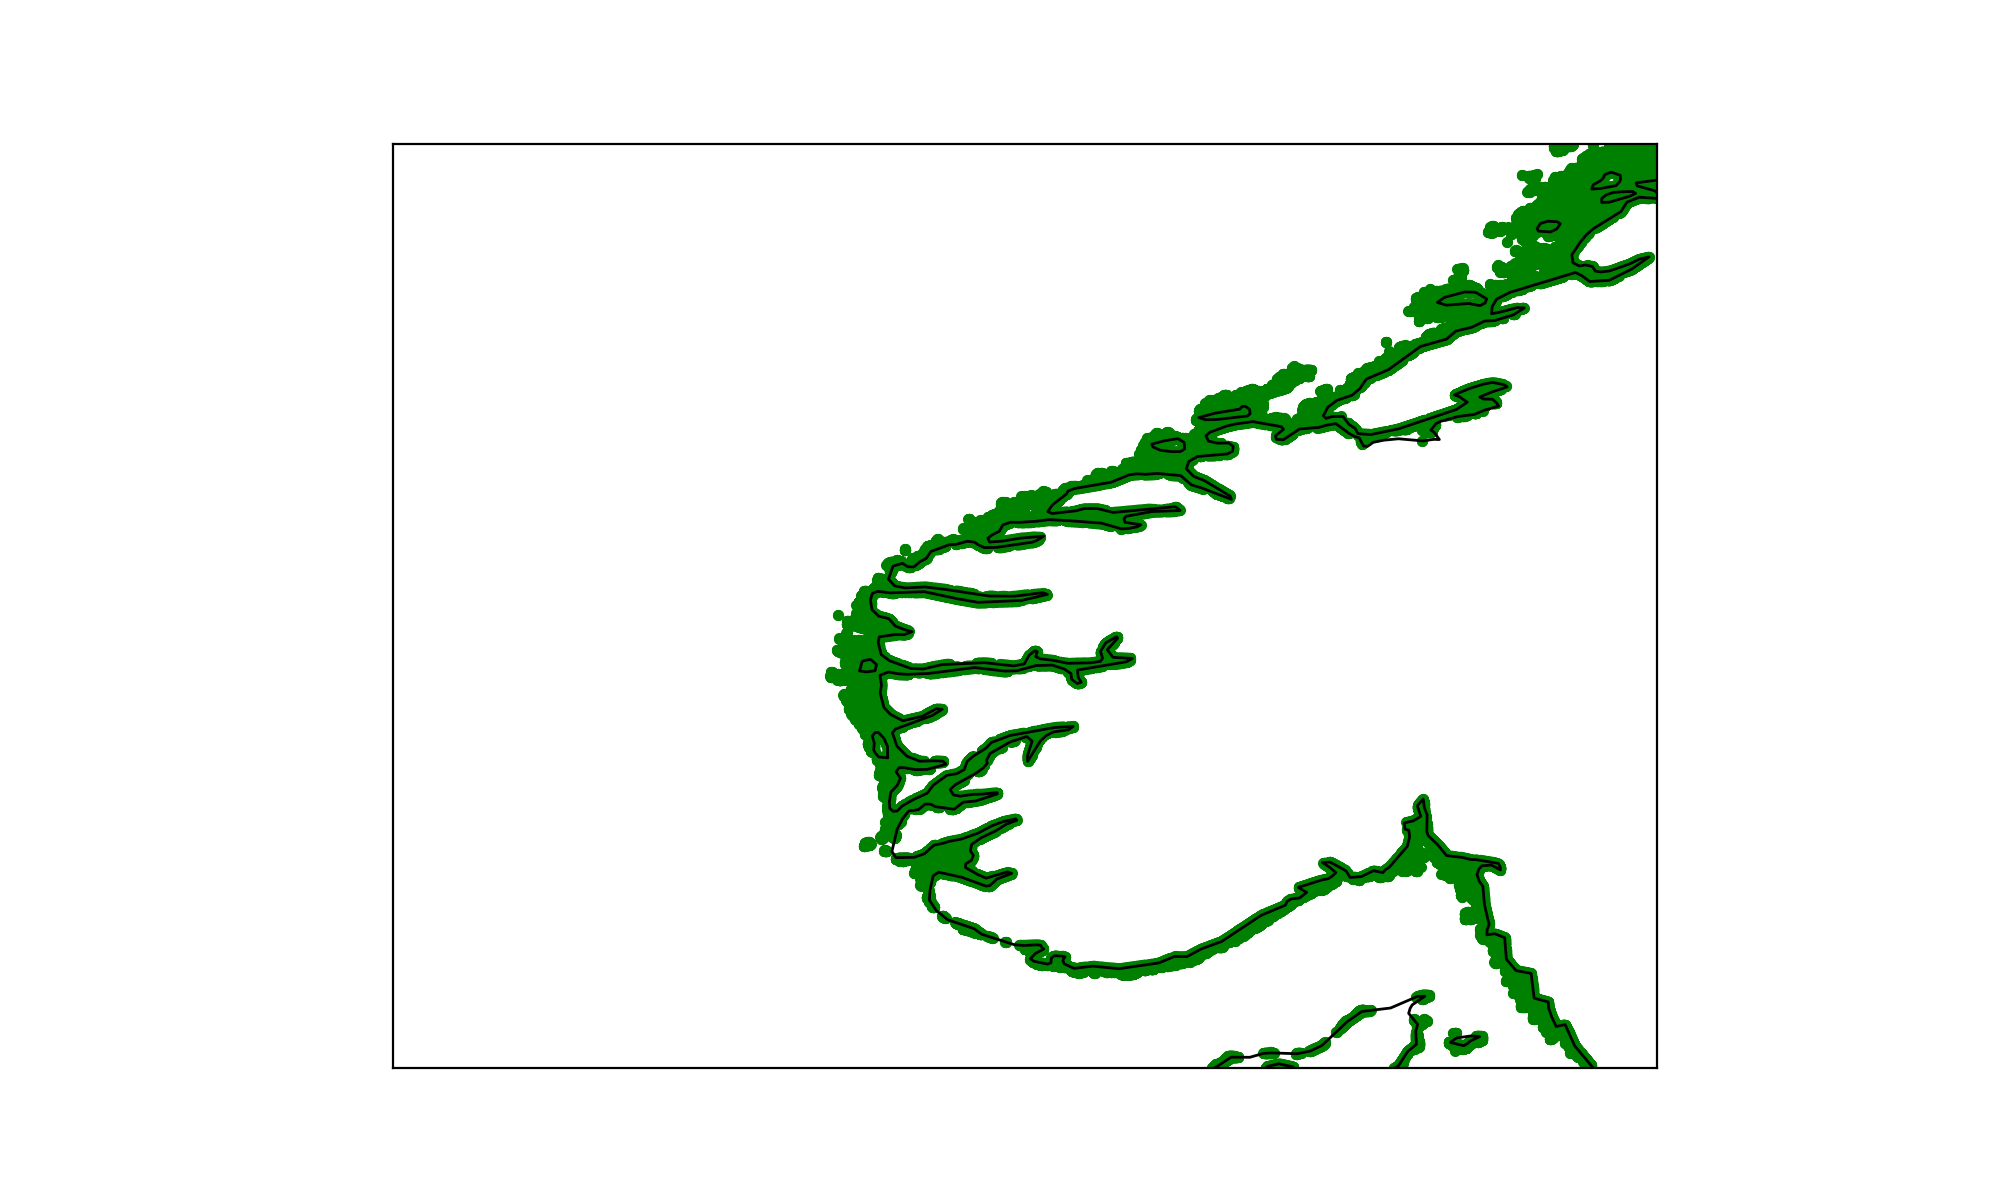

In [54]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()


m.scatter(Xlw,Ylw,color='g',marker='.') #plot

### NaNs

In [55]:
nlwmask = np.logical_and(vals==99999.,bmask) # we join the Nan value points and the land mask. That leaves out the NaNs in the water.

In [56]:
np.sum(nlwmask)

435773

In [57]:
nXlw = np.ma.masked_array(lons,mask=np.invert(nlwmask)) #mask lat/lon for water
nYlw = np.ma.masked_array(lats,mask=np.invert(nlwmask))

In [58]:
nBlw = np.ma.masked_array(vals, mask=np.invert(nlwmask))

<IPython.core.display.Javascript object>


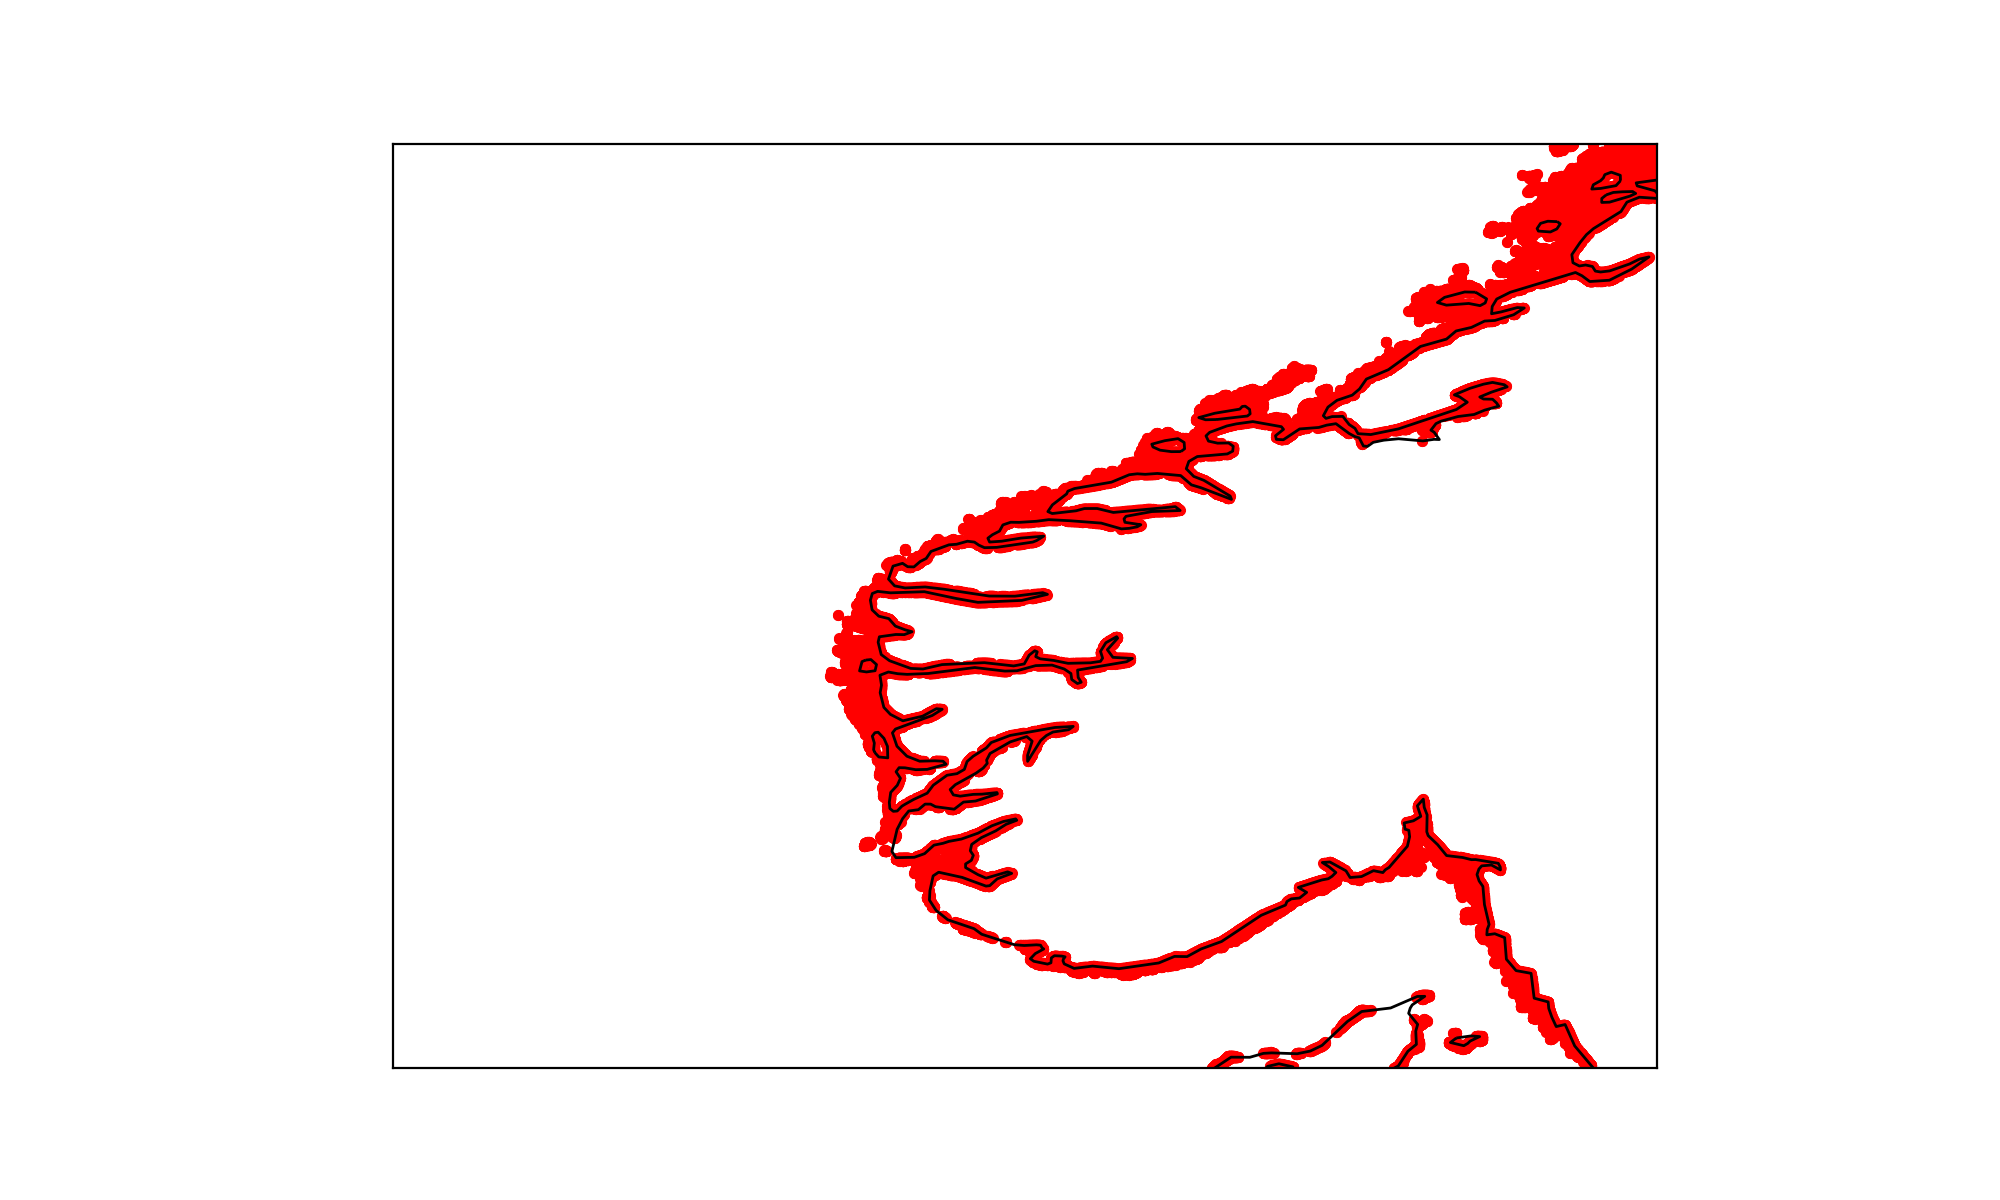

In [59]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()


m.scatter(nXlw,nYlw,color='r',marker='.') #plot

### Separate the Nan from the rest

In [60]:
np.sum(nlwmask) , np.sum(lwmask)

(435773, 440549)

In [61]:
dmask = np.logical_xor(lwmask,nlwmask) # essentialy subtract lwmask - nlwmask

In [62]:
np.sum(dmask)

4776

In [63]:
dXlw = np.ma.masked_array(lons,mask=np.invert(dmask)) #invert to mask all but the lwmask - nlwmask
dYlw = np.ma.masked_array(lats,mask=np.invert(dmask))

These are the points where the bathymetry is positive while it should be negative. If there are no NaNs these are the same as above...

In [64]:
dBlw = np.ma.masked_array(vals, mask=np.invert(dmask))

In [65]:
dBlw.min(), dBlw.max() # corresponding range

(0.009999999776482582, 14.800000190734863)

<IPython.core.display.Javascript object>


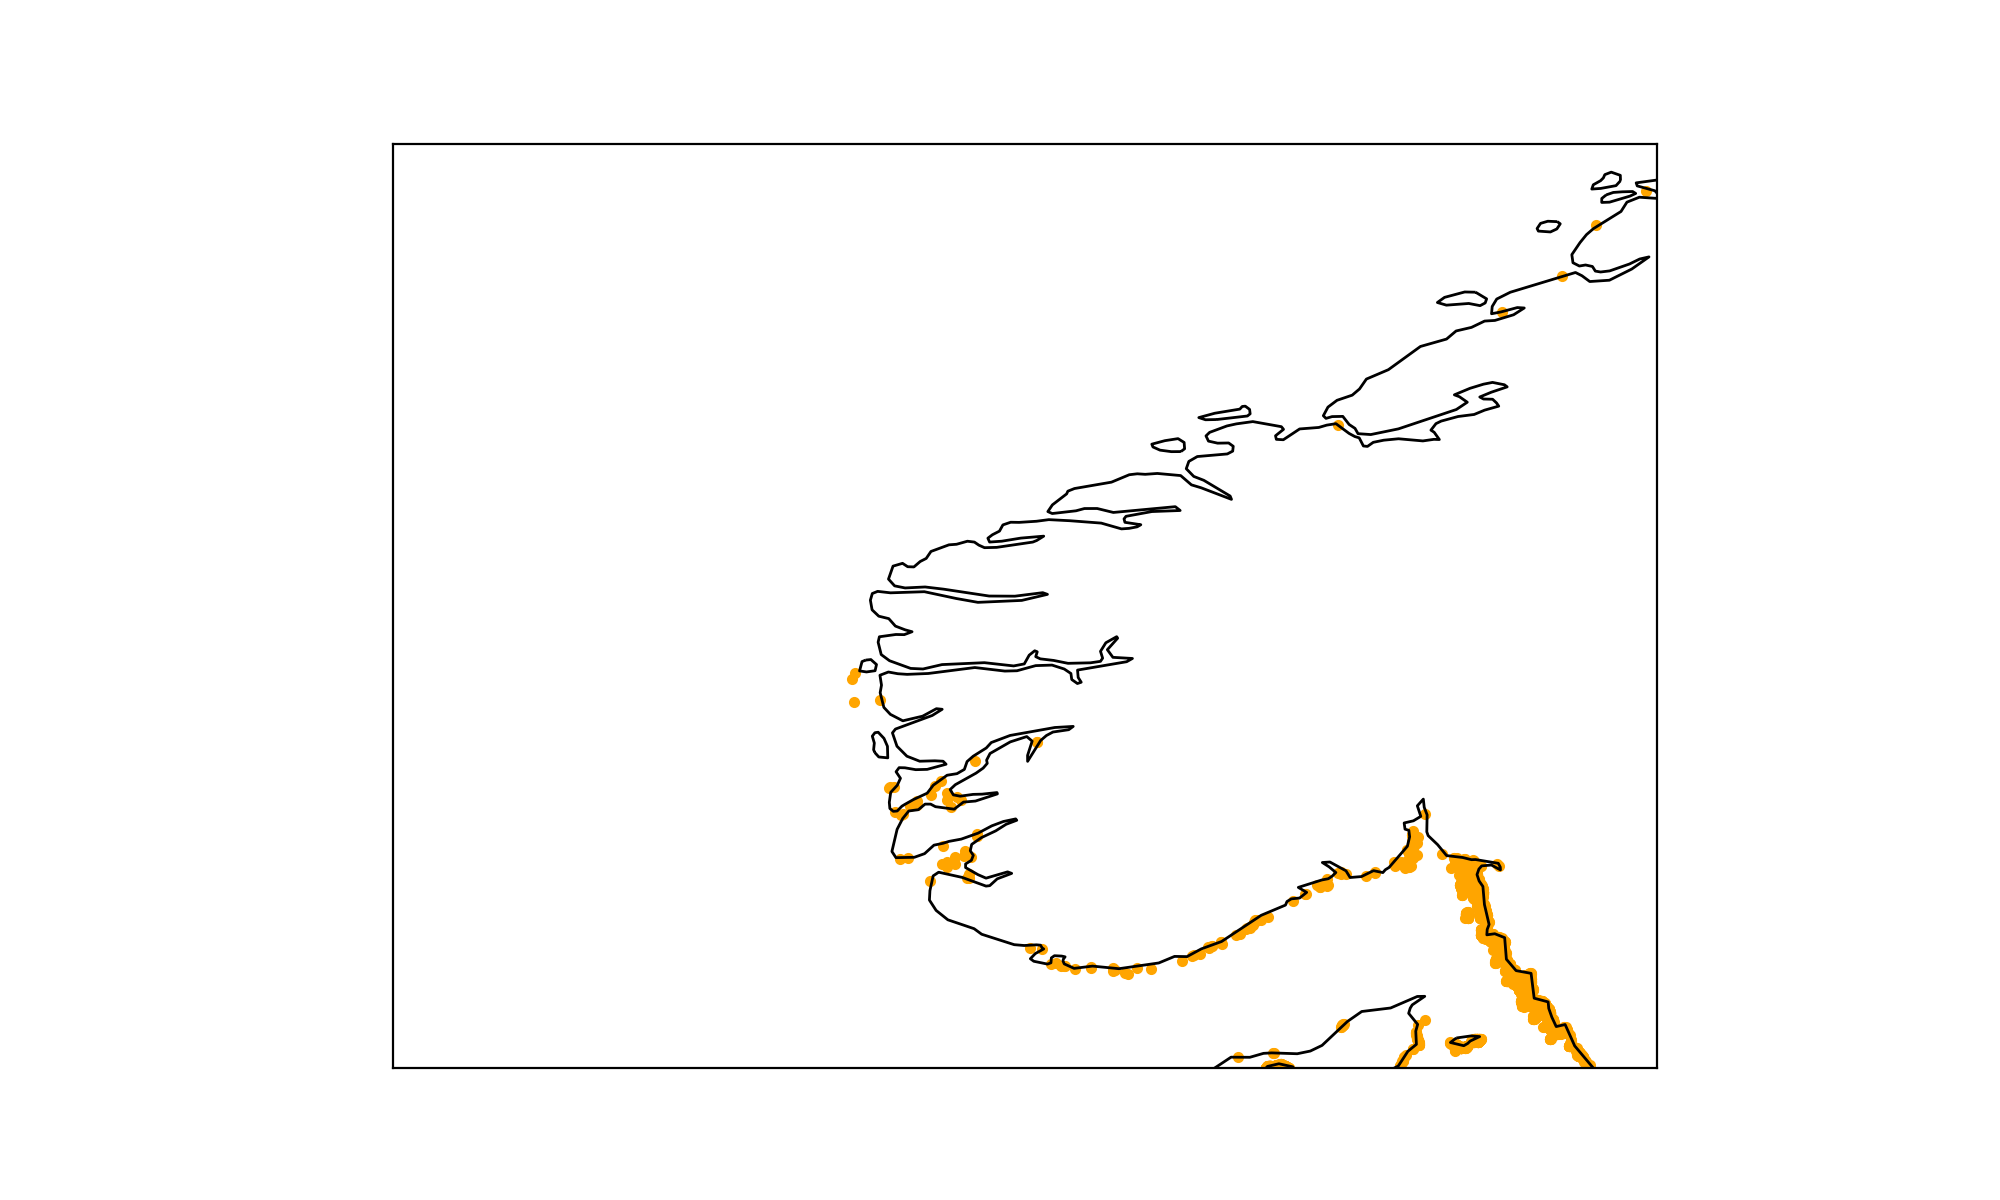

In [66]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()


m.scatter(dXlw,dYlw,color='orange',marker='.') #plot

### Error on interpolated values

The pyPoseidon dem module provides also the interpolated on the grid values. We now test those the same way...

In [67]:
ilons = b.Dataset.ilons.values.flatten()

In [68]:
ilats = b.Dataset.ilats.values.flatten()

In [69]:
gpoints=zip(ilons,ilats) # arrange the points

In [70]:
#find which points are inside the shoreline's contours
xg=[]
yg=[]
for i in range(len(cg)):
    z = geometry.Polygon(cg[i])
    path = mpltPath.Path(zip(z.boundary.xy[0],z.boundary.xy[1]))

    inside = path.contains_points(gpoints)

    if np.sum(inside) > 0:
        X = np.ma.masked_array(ilons,mask=np.invert(inside)),
        Y = np.ma.masked_array(ilats,mask=np.invert(inside))
        xg.append(X)
        yg.append(Y)

In [71]:
#merge the masks 
gmask=np.ones(xg[0][0].shape, dtype=bool)
for i in range(len(xg)):
    gmask = np.logical_and(gmask,xg[i][0].mask)

In [72]:
XG = np.ma.masked_array(ilons,gmask) #mask lat/lon
YG = np.ma.masked_array(ilats,gmask)

In [73]:
ivals = b.Dataset.ival.values.flatten()

In [74]:
ivals[np.isnan(ivals)] = 99999.

In [75]:
#### Wet on land

In [76]:
iwlmask = np.logical_and(ivals<0,np.invert(gmask)) # negative bathymetry & inside shorelines

In [77]:
np.sum(iwlmask)

97

In [78]:
iXwl = np.ma.masked_array(ilons,mask=np.invert(iwlmask)) #mask lat/lon for water
iYwl = np.ma.masked_array(ilats,mask=np.invert(iwlmask))

<IPython.core.display.Javascript object>


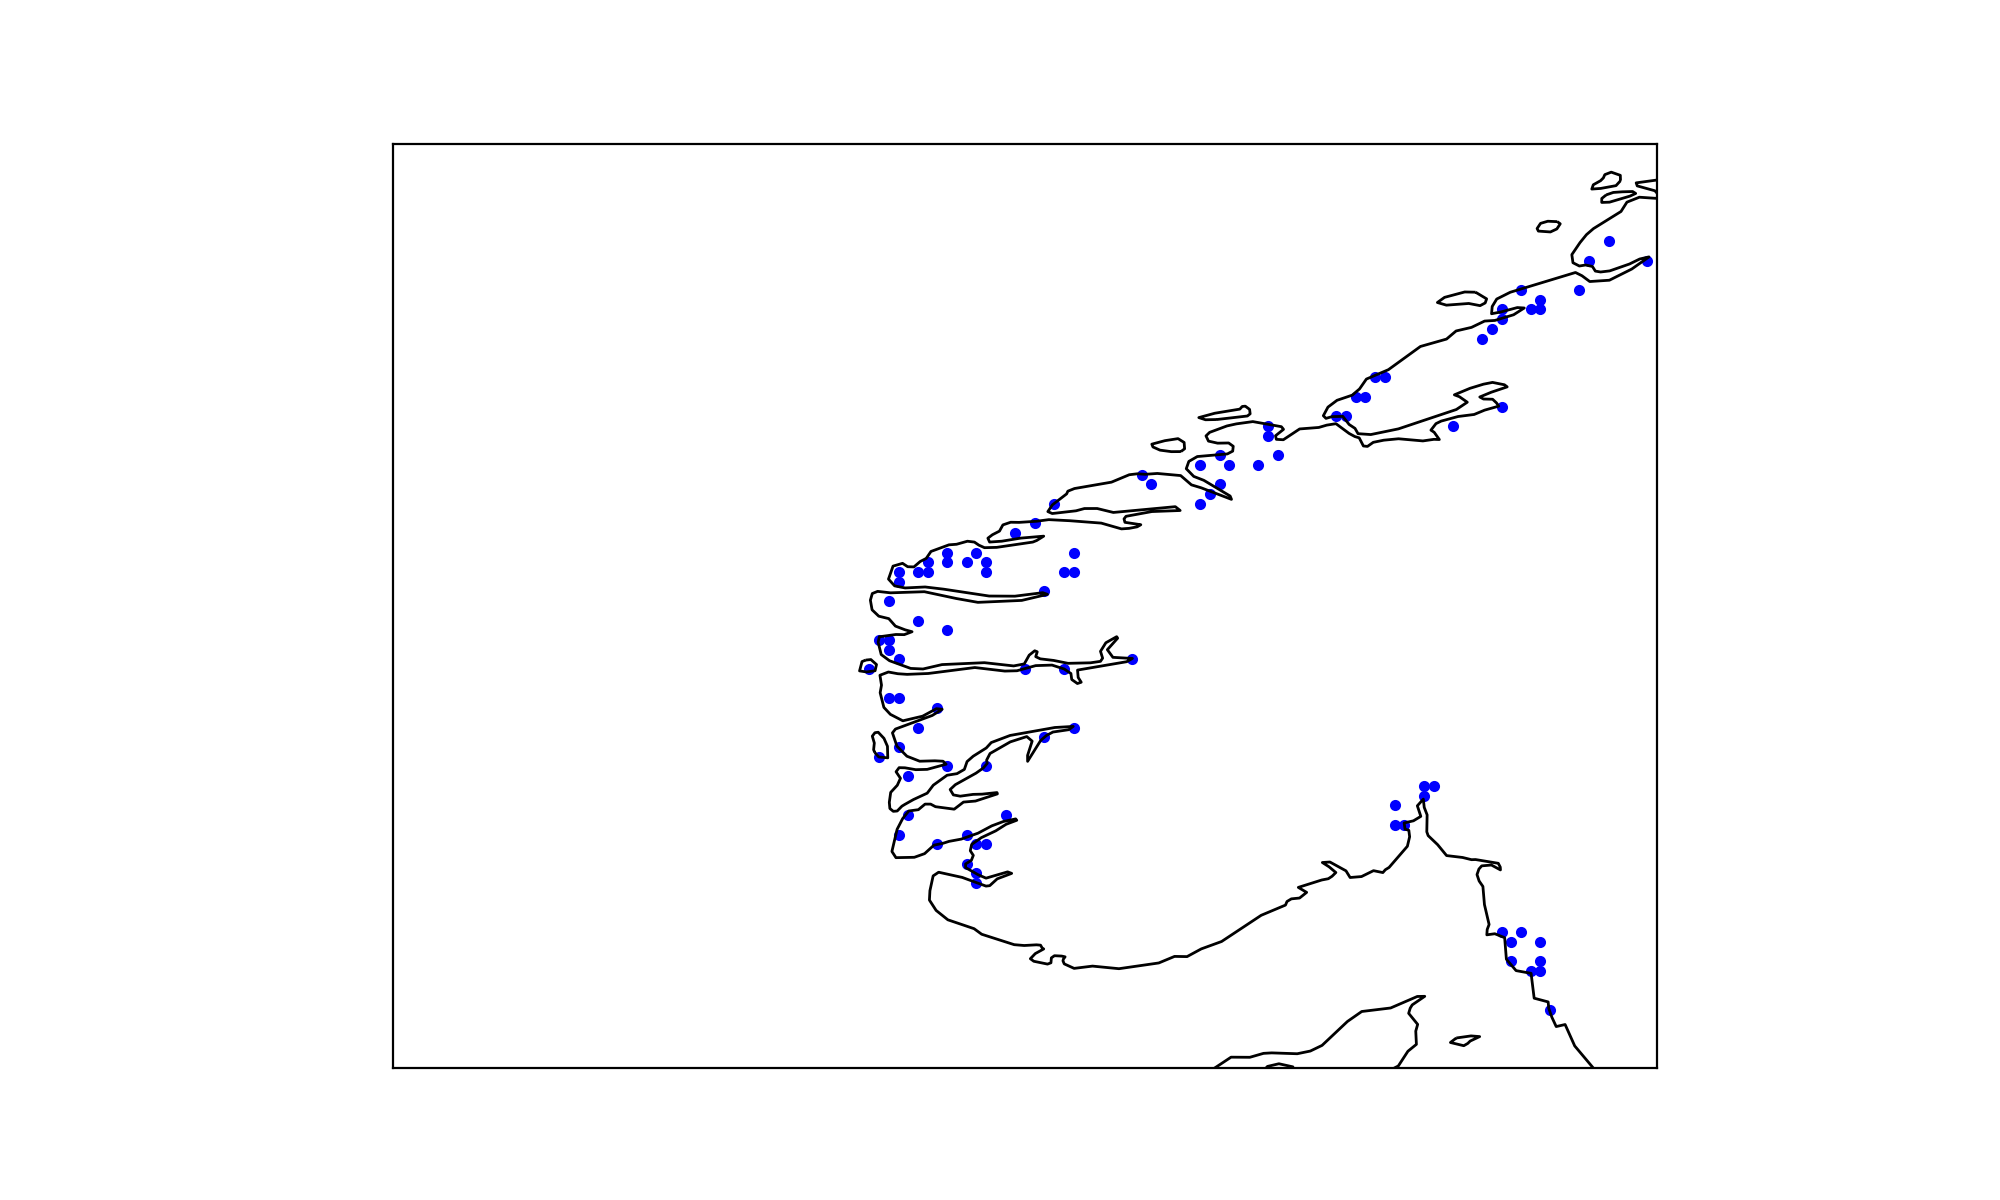

In [79]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()


m.scatter(iXwl,iYwl,color='b',marker='.') #plot the wet grid points on land

In [122]:
#### dry on water

In [80]:
ilwmask = np.logical_and(ivals>0,gmask) # positive bathymetry & outside shorelines

In [81]:
np.sum(ilwmask)

214

In [82]:
iXlw = np.ma.masked_array(ilons,mask=np.invert(ilwmask)) #mask lat/lon for water
iYlw = np.ma.masked_array(ilats,mask=np.invert(ilwmask))

In [83]:
iXlw.shape, ilons.shape

((12350,), (12350,))

In [84]:
iBlw = np.ma.masked_array(ivals, mask=np.invert(ilwmask))

In [85]:
iBlw.min(), iBlw.max()

(0.2800000011920929, 99999.0)

<IPython.core.display.Javascript object>


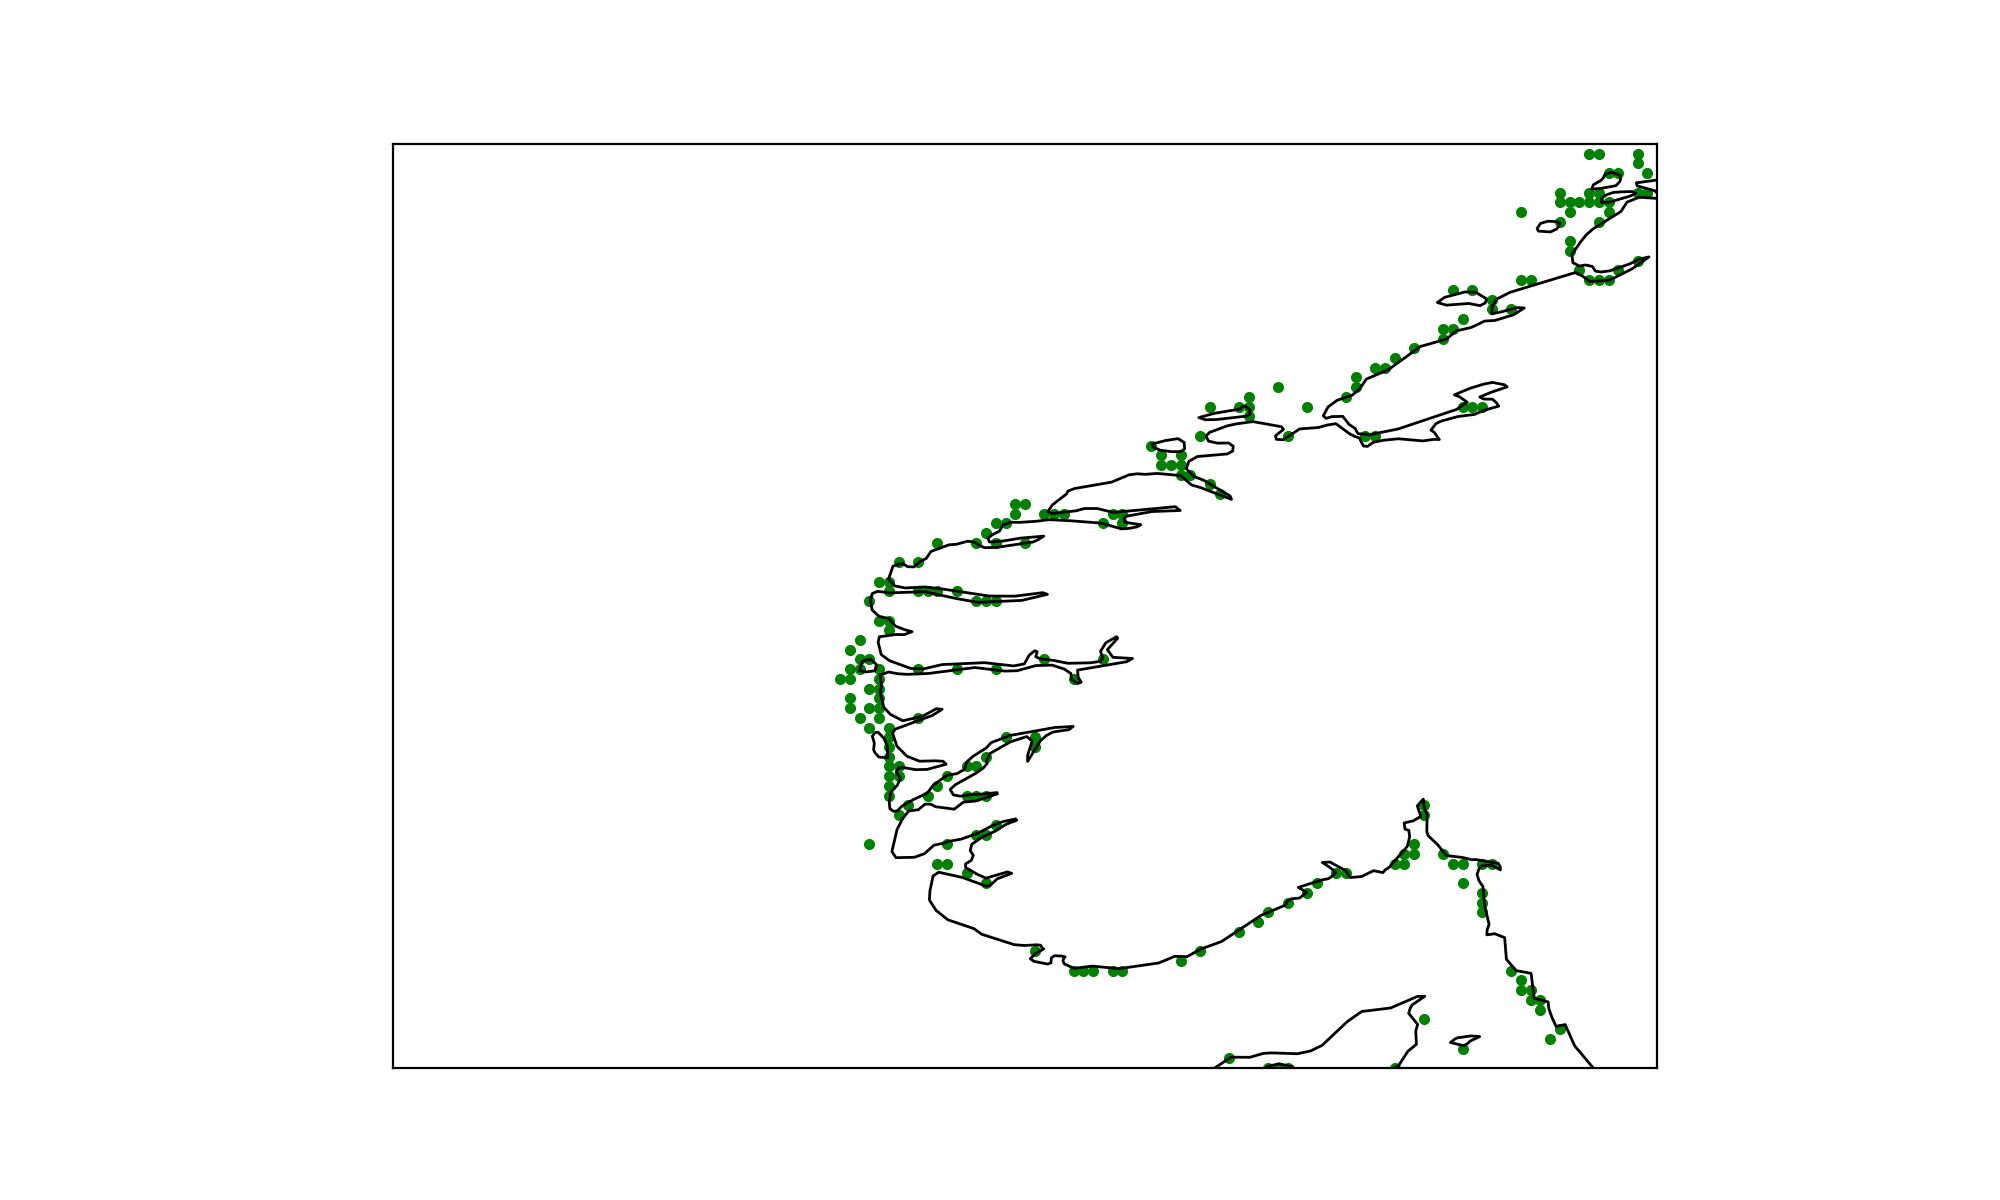

In [86]:
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()


m.scatter(iXlw,iYlw,color='g',marker='.') #plot dry & Nans points on water

### resample to fix

In [87]:
#water grid points 
gx=np.ma.masked_array(xp,wet)
gy=np.ma.masked_array(yp,wet)

In [88]:
wet_values = np.ma.masked_array(vals,vals>0) # mask all positive values from the original bathymetry

In [89]:
wet_values.fill_value = 99999. # take care of the NaN

In [90]:
wet_values

masked_array(data=[-79.11000061035156, -80.5999984741211,
                   -81.19999694824219, ..., -202.1999969482422,
                   -194.6999969482422, -181.39999389648438],
             mask=[False, False, False, ..., False, False, False],
       fill_value=99999.0)

In [91]:
# mask the positive bathymetry points like the values above to make it consistent
mx = np.ma.masked_array(lons,vals>0)  
my = np.ma.masked_array(lats,vals>0)

In [92]:
orig = pyresample.geometry.SwathDefinition(lons=mx,lats=my) # original bathymetry points with only negative values

In [93]:
targ = pyresample.geometry.SwathDefinition(lons=iXlw,lats=iYlw) # All the dry & NaN points on water

In [94]:
# with nearest using only the water values
b2_near = pyresample.kd_tree.resample_nearest(orig,wet_values,targ,radius_of_influence=150000,fill_value=99999.)

In [95]:
b2_near.min(), b2_near.max()

(-202.0, 99999.0)

In [96]:
fvals = ivals.copy() # make a copy of ivals

In [97]:
b2_near[ilwmask].min(), b2_near[ilwmask].max() #We see that the resampled values are now all negative

(-202.0, 0.0)

In [98]:
fvals[ilwmask] = b2_near[ilwmask] #replace original problematic values with the resampled ones

In [99]:
fvals = fvals.reshape(xp.shape) # reshape to get the 2D array

In [100]:
#We can check the water part of fvals by masking the land
mfvals=np.ma.masked_array(fvals,wet) 

In [101]:
mfvals.min(), mfvals.max()

(-3205.39990234375, 0.0)

In [102]:
# with nearest using only the water values
#b2_gaus = pyresample.kd_tree.resample_gauss(orig,wet,targ,radius_of_influence=50000,sigmas=2500)

#wf = lambda r: 1 - r/100000.0

# with nearest using only the water values
#b2_gauss = pyresample.kd_tree.resample_custom(orig, wet, targ,
  #                                   radius_of_influence=50e3,weight_funcs=wf)

## test on map

<IPython.core.display.Javascript object>


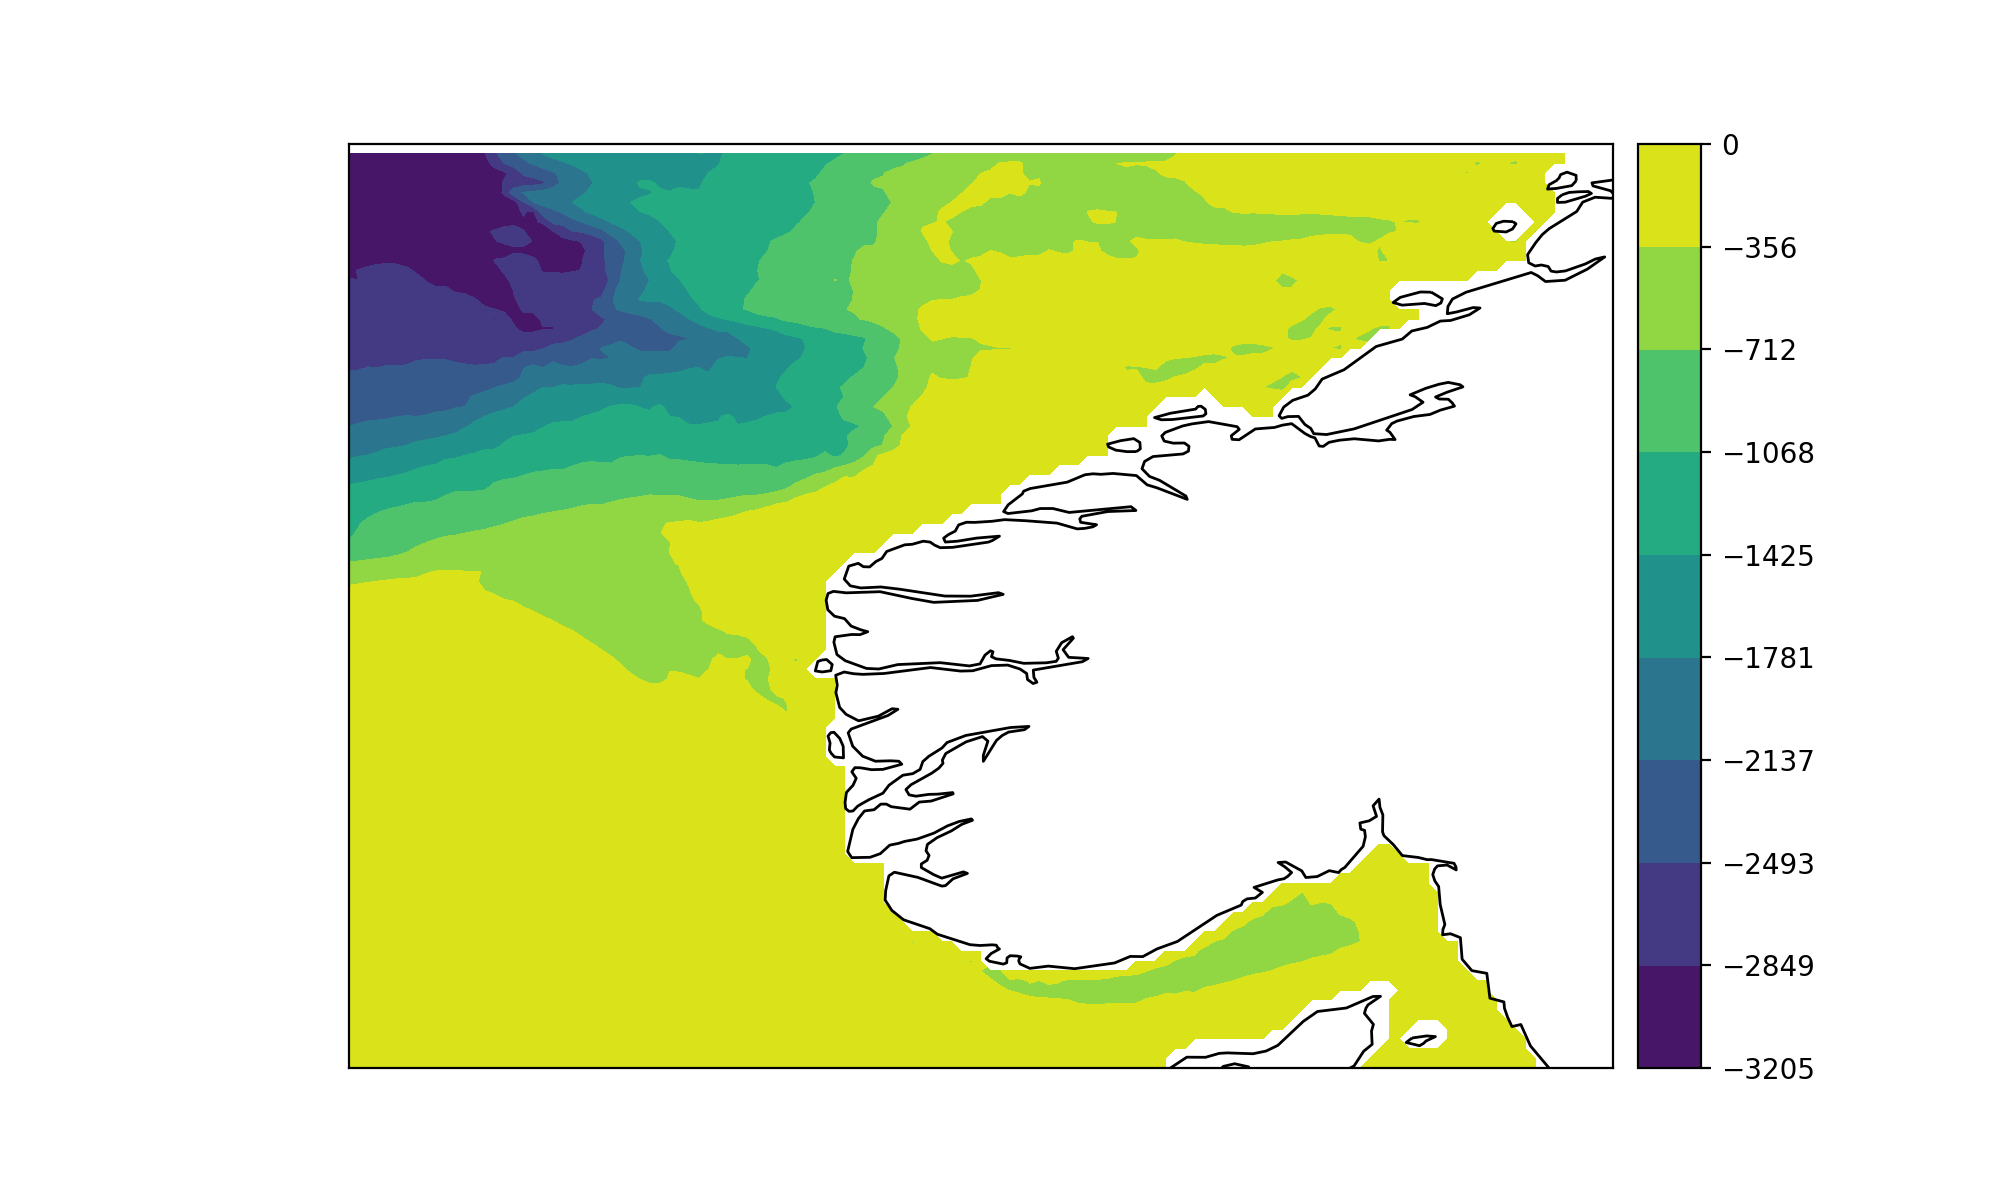

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

In [103]:
#Visualize
plt.figure(figsize=(10,6))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()

v=np.linspace(mfvals.min(),mfvals.max(),10)

m.contourf(gx,gy,mfvals,v)

m.colorbar(ticks=v)

..or..

<IPython.core.display.Javascript object>


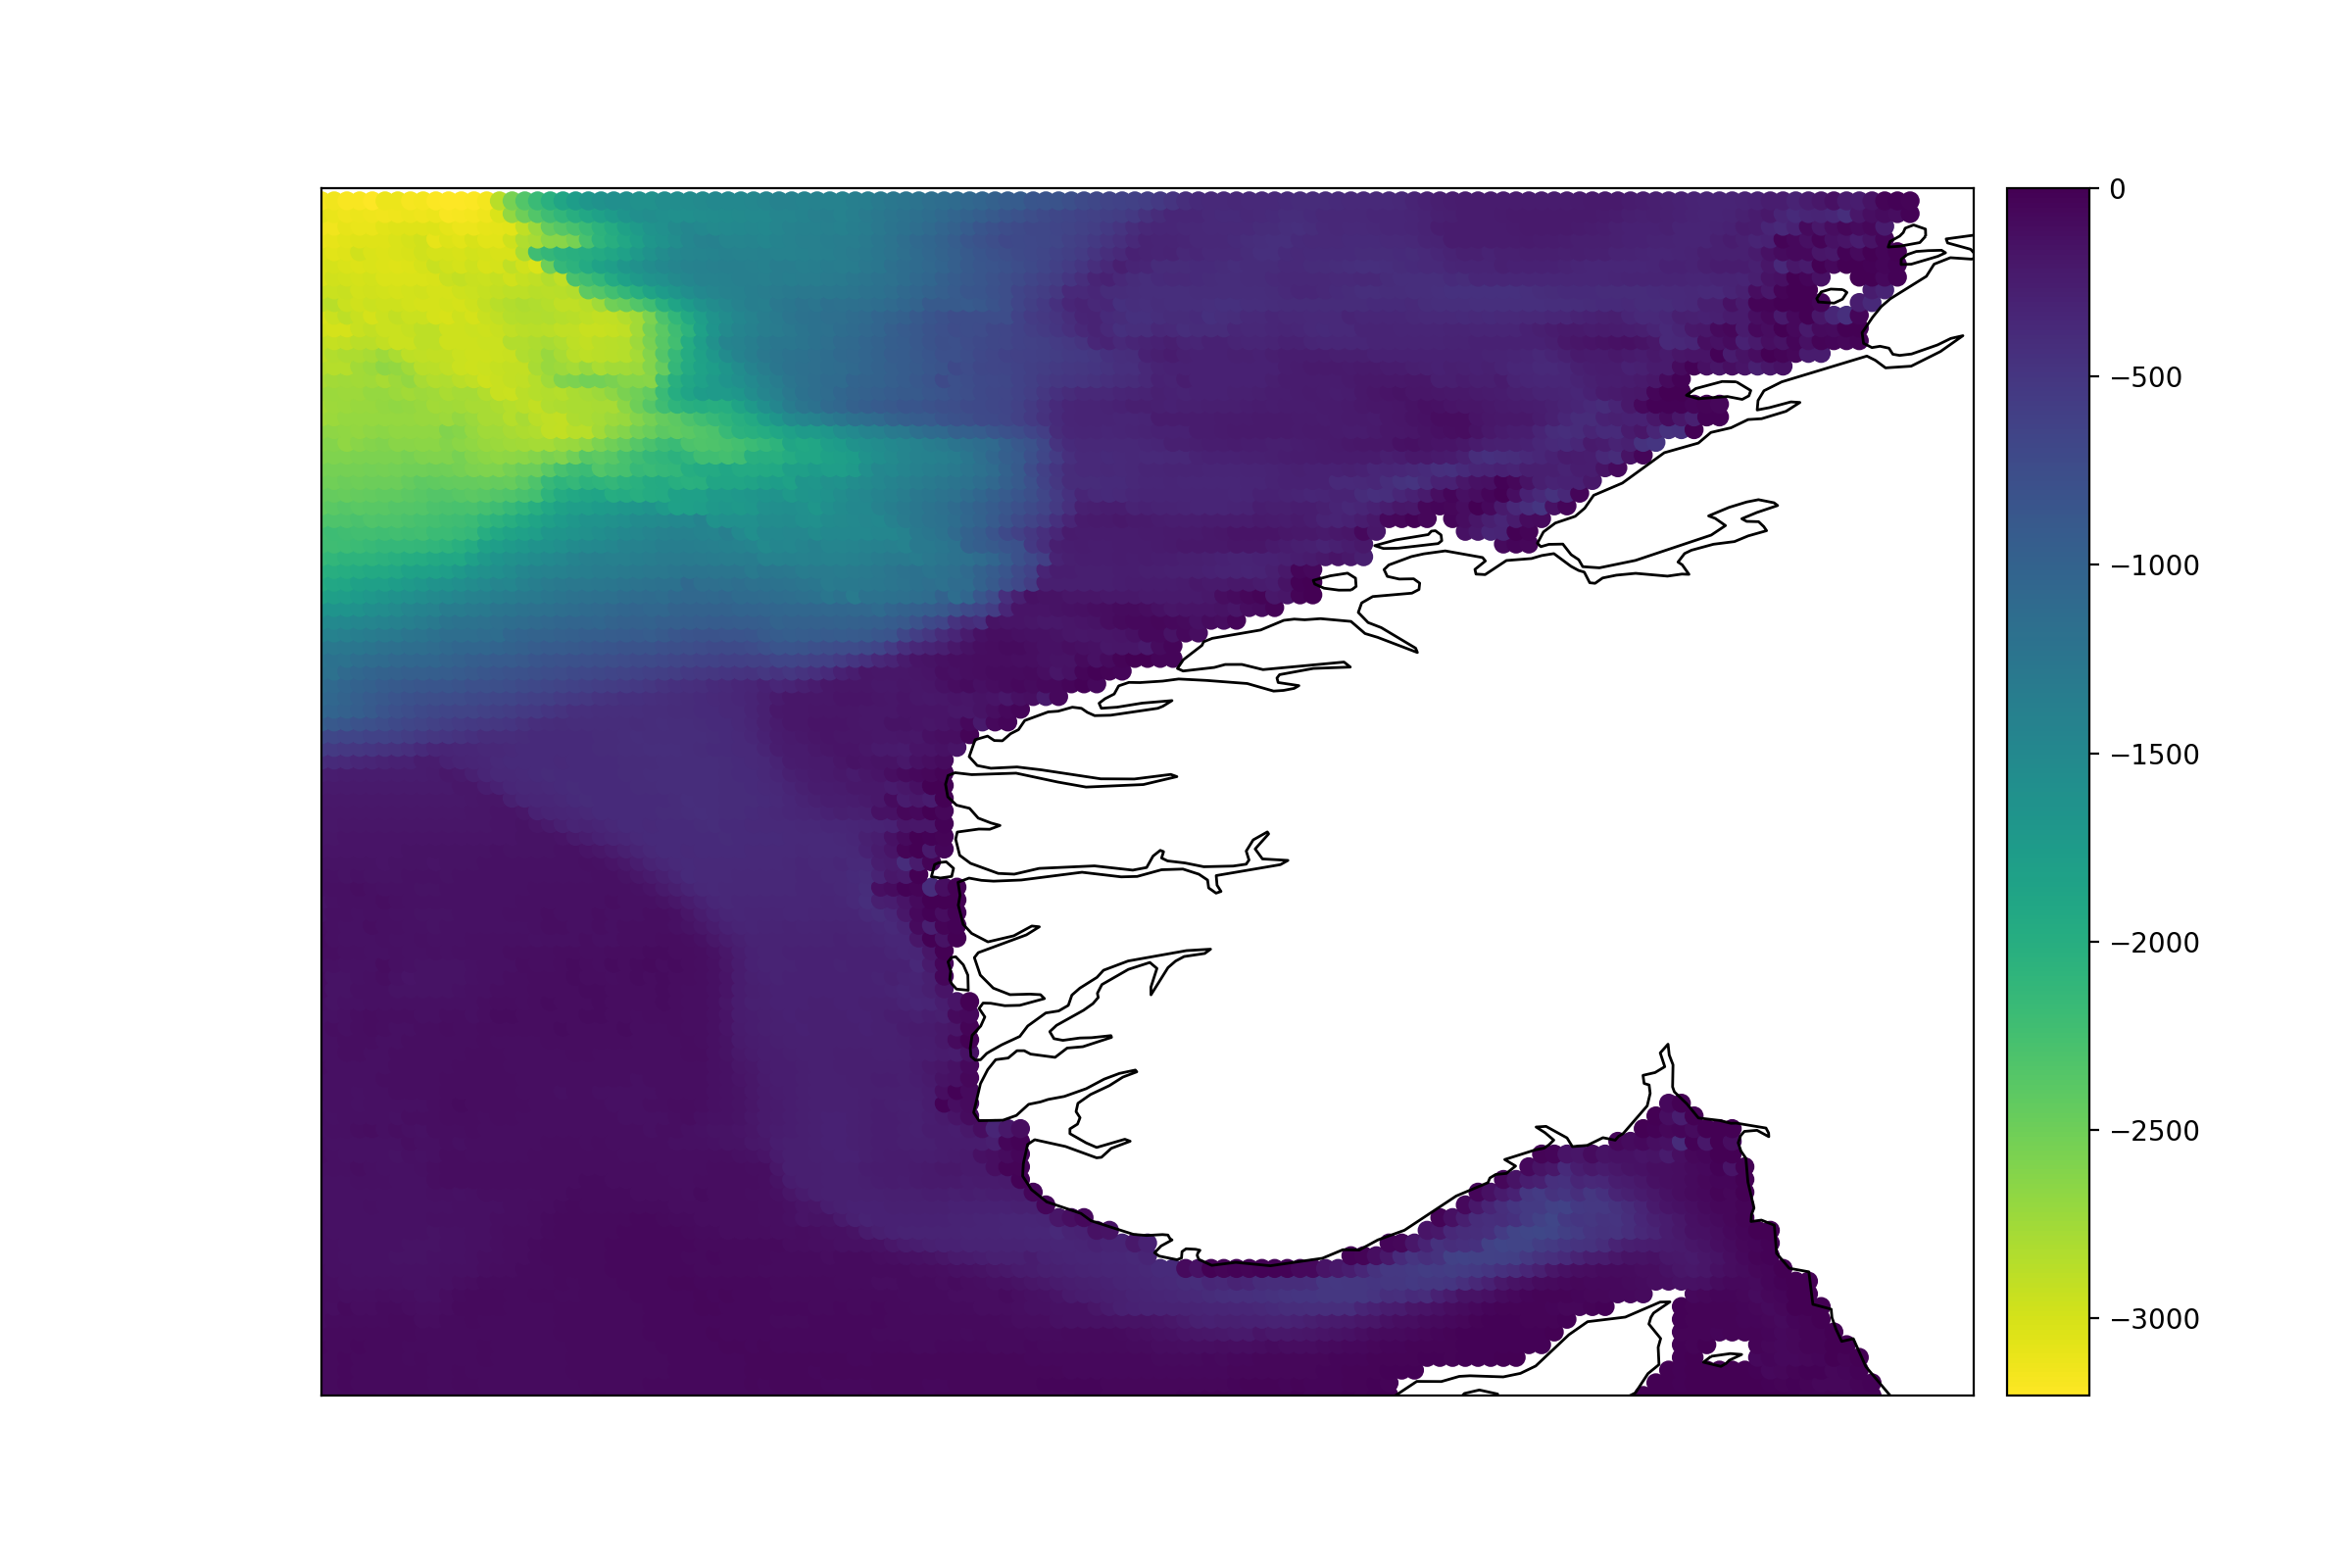

In [104]:
plt.figure(figsize=(12,8))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()
m.scatter(gx,gy,c=mfvals,cmap='viridis_r')
m.colorbar()

## Fix land points

Resample to fix the land points 

In [148]:
#land grid points 
lx=np.ma.masked_array(xp,np.invert(wet))
ly=np.ma.masked_array(yp,np.invert(wet))

In [149]:
dry_values = np.ma.masked_array(vals,vals<0) # mask all negative values from the original bathymetry

In [150]:
dry_values.fill_value = 99999. # take care of the NaN

In [151]:
dry_values

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=99999.0)

In [152]:
dry_values.min(),dry_values.max() 

(0.0, 99999.0)

In [153]:
# mask the negative bathymetry points like the values above to make it consistent
mx = np.ma.masked_array(lons,vals<0)  
my = np.ma.masked_array(lats,vals<0)

In [154]:
orig = pyresample.geometry.SwathDefinition(lons=mx,lats=my) # original bathymetry points with only negative values

In [155]:
targ = pyresample.geometry.SwathDefinition(lons=iXwl,lats=iYwl) # All the dry & NaN points on water

In [156]:
# with nearest using only the water values
b2_near = pyresample.kd_tree.resample_nearest(orig,dry_values,targ,radius_of_influence=150000,fill_value=99999.)

In [157]:
ivals[iwlmask] 

array([-5.73000002e+00, -2.99000001e+00, -1.59999996e-01, -2.61999989e+00,
       -1.33100004e+01, -1.04300003e+01, -9.03999996e+00, -4.55999994e+00,
       -1.25100002e+01, -2.13999996e+01, -6.10000000e+01, -2.01199997e+02,
       -6.75999985e+01, -2.05199997e+02, -5.54000015e+01, -2.02999992e+01,
       -3.32100006e+02, -1.10000002e+00, -6.88000031e+01, -7.84000015e+01,
       -2.53600006e+02, -6.30000000e+01, -1.01400002e+02, -5.69999981e+00,
       -1.60000000e+01, -3.01500000e+02, -2.00399994e+02, -5.19400024e+02,
       -2.23999996e+01, -9.11999969e+01, -2.69000000e+02, -3.53799988e+02,
       -3.05799988e+02, -3.24000015e+01, -5.05200012e+02, -1.41800003e+02,
       -3.54000015e+01, -1.16719995e+03, -8.48000000e+02, -2.21399994e+02,
       -2.02199997e+02, -2.47999992e+01, -1.15000000e+02, -1.00000000e+02,
       -1.65000000e+02, -4.82000008e+01, -3.16200012e+02, -1.03999996e+01,
       -8.18000031e+01, -1.63999996e+01, -2.04000000e+02, -3.70000000e+01,
       -3.94799988e+02, -

In [158]:
b2_near[iwlmask]

array([9.99990000e+04, 9.99990000e+04, 1.80000007e-01, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
       9.99990000e+04, 9.99990000e+04, 9.99990000e+04, 9.99990000e+04,
      

In [159]:
b2_near.min(), b2_near.max()

(0.18000000715255737, 99999.0)

In [160]:
lfvals = ivals.copy() # make a copy of ivals

In [161]:
b2_near[iwlmask].min(), b2_near[iwlmask].max() #We see that the resampled values are now all negative

(0.18000000715255737, 99999.0)

In [162]:
lfvals[iwlmask] = b2_near[iwlmask] #replace original problematic values with the resampled ones

In [163]:
lfvals = lfvals.reshape(xp.shape) # reshape to get the 2D array

In [164]:
#We can check the water part of fvals by masking the land
lmfvals=np.ma.masked_array(lfvals,np.invert(wet)) 

In [165]:
lmfvals.min(), lmfvals.max()

(-1223.4000244140625, 99999.0)

In [166]:
lx.shape, lfvals.shape

((95, 130), (95, 130))

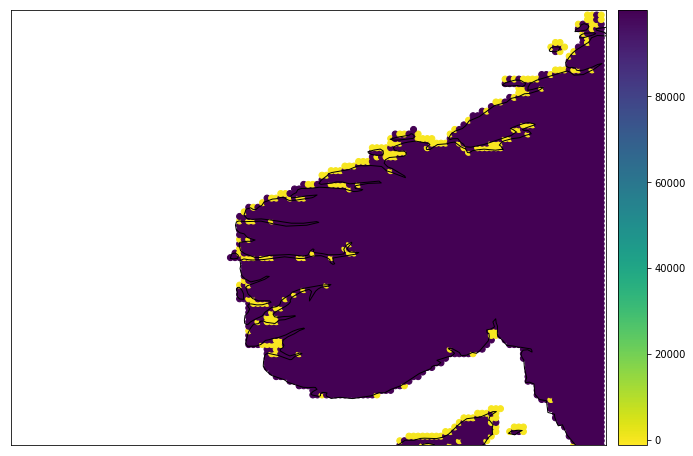

In [167]:
plt.figure(figsize=(12,8))
m = Basemap(llcrnrlon=dic['minlon'], llcrnrlat=dic['minlat'], urcrnrlon=dic['maxlon'], urcrnrlat=dic['maxlat'],
            resolution='i')  # resolution = (l)ow | (m)edium | (h)igh
m.drawcoastlines()
#m.drawcountries()
m.scatter(lx,ly,c=lmfvals,cmap='viridis_r')
m.colorbar()